# Physics Constrain Autoencoders

By Joshua C. Agar, Mary Ye

* There are many times where you want to fit spectroscopic data to a model
* Classical fitting methods can be used but break down:
  * When data is noisy
  * There are multiple candidate models
  * Data is high velocity
  * Data is noisy





# Autoencoder

![imag](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/Autoencoder.png?raw=true)

* **Encoder** - Neural network that deconstructs the data into the most important statistical components
* **Embedding Layer(s)** - One or many layers were information is extracted
* **Decoder** - Neural network that translates the latent space to original dimensionality. 

## Mathamatical Objective
* Minimize the reconstruction loss based on some metric. 
  * Mean squared errror

  Good at avoiding influence of anomalies
  * Mean absolute error

  Good at capturing details within spectra

## Optimizers
* Standard optimizers like ADAM tend to be suffiecent
* Can use more complex optimizers 2nd order, adhessian to optimize small models. 

## Practical Objective
* Create an autoencoder that has performant reconstruction
* Create a low-dimensional and interpretable latent space
  * Reduce the dimensionality
  * Impose non-negativity contraints
  * Impose regularization
  * Impose sparsity
  * Impose constraints on the shape of the latent distribution
  * Impose soft-constraints that favor disentanglement
* Create a latent trajectory that is suitable for generation 

In [1]:
# Clones a repository with some utility codes
!git clone https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial.git

Cloning into 'AI_For_Atoms_Autoencoder_Tutorial'...
remote: Enumerating objects: 130, done.
remote: Counting objects: 100% (130/130), done.
remote: Compressing objects: 100% (98/98), done.
remote: Total 130 (delta 54), reused 90 (delta 30), pack-reused 0
Receiving objects: 100% (130/130), 8.76 MiB | 6.62 MiB/s, done.
Resolving deltas: 100% (54/54), done.


In [2]:
cd AI_For_Atoms_Autoencoder_Tutorial/

/content/AI_For_Atoms_Autoencoder_Tutorial


In [3]:
# Updates the repository
!git pull https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial.git

From https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial
 * branch            HEAD       -> FETCH_HEAD
Already up to date.


# Imports Packages

In [4]:
# Installs a custom package
!pip install -U git+https://github.com/m3-learning/DeepMatter.git

from skimage import io
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.nn.functional as F
import torch.autograd as autograd
import torch.optim as optim
import tensorflow as tf
import torch
from tqdm import tqdm
import os
from torchsummary import summary

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID" 
os.environ["CUDA_VISIBLE_DEVICES"]="0"

plt.rcParams.update({'xtick.direction': 'in', 'ytick.direction':'in'})

import os

  Cloning https://github.com/m3-learning/DeepMatter.git to /tmp/pip-req-build-f6bjh_d7
  Running command git clone -q https://github.com/m3-learning/DeepMatter.git /tmp/pip-req-build-f6bjh_d7
  Created wheel for DeepMatter: filename=DeepMatter-0.0.14-py3-none-any.whl size=16791 sha256=e377db110c4b9a8c57b0bc7b6974567c83d0029505948ece04058120effe32a6
  Stored in directory: /tmp/pip-ephem-wheel-cache-kj77gslp/wheels/73/a0/4f/775f8d4229551544b6c8a8196a3d0be9b02b6ac4319b43a2b9
Successfully built DeepMatter


In [5]:
# Imports Custom packages
import AE_tutorial.viz as viz
import AE_tutorial.util as util
import AE_tutorial.nn_util as nn_util

import DeepMatter as dm
from DeepMatter.spectral_fitters.gaussian import Gaussian
from DeepMatter.spectral_fitters.voigt import PseudoVoigt
from DeepMatter.spectral_fitters import nn as dm_nn
from DeepMatter.rand_util.rand_gen import rand_tensor

from torch.utils.data import Dataset, DataLoader
import torch
import numpy as np
import matplotlib.pyplot as plt


import time
import math
from DeepMatter.util.torch_util import Dataset_Generator

## Generating some data based on the image
### Define a non-linear function

$$A*sin(2 \pi f+ \phi)$$

In [6]:
class Sin_func:

    """
    Class that computes the Sin function
    """

    def __init__(
        self,
        x_vector,
        amp=[0, 1],
        phase=[0, 1],
        frequency=[0, 1],
        size=(1, 1),
        batch_size=1000,
        verbose=False,
        ):
        """

        Args:
            x_vector:
            sd (array, float): range for the standard deviation
            mean (array, float): range for the mean
            amp (array, float): range for the amplitude
            size (tuple): Size of the array first index is number of channels, second is number of functions
            verbose (bool): shows outputs
        """

        self.x_vector = x_vector
        self.batch_size = batch_size

        self.amp = amp
        self.amp_mean = torch.tensor(amp[0] + amp[1]) / 2
        self.amp_sd = torch.sqrt(torch.pow(torch.tensor(amp[1])
                                 - torch.tensor(amp[0]), 2) / 12)

        self.phase = phase
        self.phase_mean = torch.tensor(phase[0] + phase[1]) / 2
        self.phase_sd = torch.sqrt(torch.pow(torch.tensor(phase[1])
                                   - torch.tensor(phase[0]), 2) / 12)

        self.frequency = frequency
        self.frequency_mean = torch.tensor(frequency[0] + frequency[1]) \
            / 2
        self.frequency_sd = \
            torch.sqrt(torch.pow(torch.tensor(frequency[1])
                       - torch.tensor(frequency[0]), 2) / 12)

        self.size = size
        self.verbose = verbose

    def compute(self, params, device='cpu'):
        """

        Args:
            self (object): Returns the instance itself.
            device (string, optional) : Sets the device to do the computation. Default `cpu`, common option `cuda`

        Returns: out (Tensor): spectra.

        """

        if len(params.size()) == 2:
            params = torch.reshape(params, (params.shape[0], 3, -1))

        out = torch.zeros((params.shape[0], self.x_vector.shape[0],
                          self.size[0], self.size[1]))

        params = params.to(device)

        for i in range(self.size[1]):

            if params.ndim == 4:
                _amp = params[:, 0, 0, i]
                _phase = params[:, 0, 1, i]
                _frequency = params[:, 0, 2, i]

            if params.ndim == 3:
                _amp = params[:, 0, i]
                _phase = params[:, 1, i]
                _frequency = params[:, 2, i]

            x_vector = torch.cat(params.shape[0]
                                 * [self.x_vector]).reshape(params.shape[0],
                    -1).to(device)
            x_vector = torch.transpose(x_vector, 0, 1)  # .to(device)

            _out = _amp * torch.sin(2 * torch.tensor(np.pi)
                                    * _frequency * x_vector + _phase)

            out[:, :, 0, i] = torch.transpose(_out, 0, 1)

        return (torch.sum(out, dim=3), out)

    def sampler(self, device='cpu'):
        """

        Args:
            device (str): device where computation happens

        Returns:
            out (Tensor) : Generated spectra
            params (Tensor) : parameters used for generation

        """

        phase = rand_tensor(min=self.phase[0], max=self.phase[1],
                            size=(self.batch_size, self.size[0],
                            self.size[1]))
        frequency = rand_tensor(min=self.frequency[0],
                                max=self.frequency[1],
                                size=(self.batch_size, self.size[0],
                                self.size[1]))
        amp = rand_tensor(min=self.amp[0], max=self.amp[1],
                          size=(self.batch_size, self.size[0],
                          self.size[1]))
        _params = torch.torch.stack((amp, phase, frequency))

        _params = torch.atleast_2d(_params)
        _params = torch.transpose(_params, 0, 1)
        _params = torch.transpose(_params, 1, 2)

        return (self.compute(_params, device=device), _params)


In [7]:
constructor = Sin_func(amp = [.2, 1],  # Sets the amplitude
                      phase = [0, 2*np.pi], # Sets the phase
                      frequency = [0.1, .5], # Sets the frequency
                      x_vector = torch.linspace(0, np.pi, 100), # Sets the x_vector
                      batch_size = 10000) # number of samples to generate

In [8]:
# initializes the constructor
output = constructor.sampler()

# grabs the parameters and the spectra
spectra, params = output

# This grabs the sum of all spectras and the individual spectra if they exist
spectra_full, spectras = spectra

# Visualize and example generated curve

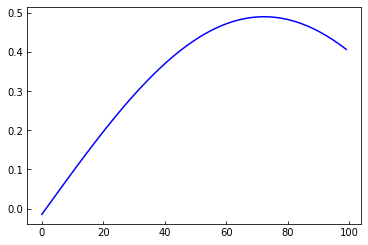

In [9]:
rand = np.random.randint(0,10000)
plt.plot(spectras[rand,:,0].cpu(),'b')

# Recurrent Neural Network Autoencoders
* The above example did not consider the temporal information in the data. 
* This can be improved by using a recurrent neural network that processes each time step sequentially.
* To add an understanding about the short and long term information in the data you can add memory and forget logic as a learnable parameter.

![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/Autoencoder_Med.png?raw=true)

![](https://github.com/jagar2/AI_For_Atoms_Autoencoder_Tutorial/blob/main/img/LSTM%20Node.png?raw=true)

## Builds the autoencoder

In [10]:
class Encoder(nn.Module):

    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Encoder, self).__init__()
        self.lstm = nn.LSTM(1, 12, batch_first=True, bidirectional=True)
        self.lstm2 = nn.LSTM(24, 12, batch_first=True,
                             bidirectional=True)
        self.embedding = nn.Linear(24, self.latent_dim)
        self.relu = nn.ReLU()

    def forward(self, x):
        (x, (_, __)) = self.lstm(x)
        (x, (_, __)) = self.lstm2(x)
        x = x[:, -1, :]
        x = self.embedding(x)
        return x


class Decoder(nn.Module):

    def __init__(self, latent_dim=12):
        self.latent_dim = latent_dim
        super(Decoder, self).__init__()
        self.lstm = nn.LSTM(self.latent_dim, 12, batch_first=True,
                            bidirectional=True)
        self.lstm2 = nn.LSTM(24, 12, batch_first=True,
                             bidirectional=True)
        self.tdd = nn.Conv1d(24, 1, 1)

    def forward(self, x):
        x = x[:, :, None]
        x = x.transpose(1, 2)
        x = x.repeat([1, 100, 1])
        (x, (_, __)) = self.lstm(x)
        (x, (_, __)) = self.lstm2(x)
        x = x.transpose(1, 2)
        x = self.tdd(x)
        x = x.transpose(1, 2)
        return x


In [11]:
class Autoencoder(nn.Module):

    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, x):

        # encode

        embedding = self.encoder(x)

        # decode

        predicted = self.decoder(embedding)

        return predicted


Since we know there are intrinsically 3 latent dimensions let's try and train the model.

In [12]:
device = 'cuda'
latent_dim = 3

encoder = Encoder(latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer

optimizer = optim.Adam(model.parameters(), lr=3e-5)

In [13]:
# views the model

model

Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=3, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(3, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

In [14]:
# constructs a dataloader for training

dataloader = DataLoader(spectra_full, batch_size=512, shuffle=True,
                        num_workers=0)

In [ ]:
# trains the model

torch.manual_seed(0)
nn_util.Train(
    model,
    encoder,
    decoder,
    dataloader,
    optimizer,
    500,
    )

In [16]:
# functions used to grab embbedings and predictions


def transform_nn(data, encoder, decoder):

    encoded_spectra = encoder(torch.tensor(np.atleast_3d(data),
                              dtype=torch.float32).to(device))

    decoded_spectra = decoder(encoded_spectra)

    encoded_spectra = encoded_spectra.to('cpu')
    encoded_spectra = encoded_spectra.detach().numpy()
    decoded_spectra = decoded_spectra.to('cpu')
    decoded_spectra = decoded_spectra.detach().numpy()
    return (encoded_spectra, decoded_spectra)

# Visualize the reconstruction

In [17]:
# computes an example reconstruction for a minibatch

(encoded_, decoded_) = transform_nn(next(iter(dataloader)), encoder,
                                    decoder)

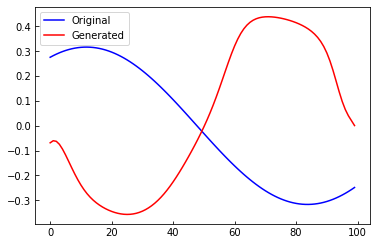

In [18]:
# plots a random example of the origina and predicted spectra

rand = np.random.randint(0, 512)
plt.plot(spectras[rand, :, 0].cpu(), 'b', label='Original')
plt.plot(decoded_[rand].squeeze(), 'r', label='Generated')
plt.legend()

# Generating Data as validation
* We want to generate a hyperspectral image
* This can be done by taking the RGB values of an image and using them as parameters for a function

## Loads and image of my dog Nala
* Painting by *Irene Dogmatic*

In [19]:
# Loads dog image

image = io.imread('./nala.jpg')

# Crops dog image

image = image[200:1900:20, 100:1500:20] / 255

## Displays the image

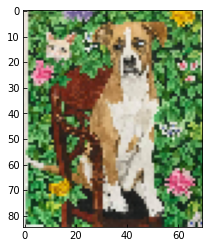

In [20]:
plt.imshow(image)

In [21]:
# Converts the image into parameters withing the generated range

nala_params = np.atleast_3d(image.reshape(-1, 3))

nala_amp = torch.tensor(nala_params[:, 0, 0] * .8 + .2)
nala_phase = torch.tensor(nala_params[:, 1, 0] * 2 * np.pi)
nala_frequency = torch.tensor(nala_params[:, 2, 0] * .5 + .1)

_nala_params = torch.torch.stack((nala_amp, nala_phase, nala_frequency))

_nala_params = torch.atleast_3d(_nala_params)
_nala_params = torch.transpose(_nala_params, 0, 1)

In [22]:
# builds the spectra from the parameters

(nala_spectra, _) = constructor.compute(_nala_params)

# generated the encoded representation and decoded spectra

(nala_encoded_, nala_decoded_) = transform_nn(nala_spectra, encoder,
        decoder)

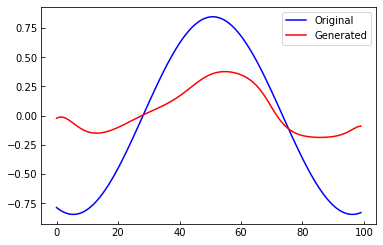

In [23]:
# plots a random example of the origina and predicted spectra

rand = np.random.randint(0, nala_spectra.shape[0])
plt.plot(nala_spectra[rand, :, 0].cpu(), 'b', label='Original')
plt.plot(nala_decoded_[rand].squeeze(), 'r', label='Generated')
plt.legend()


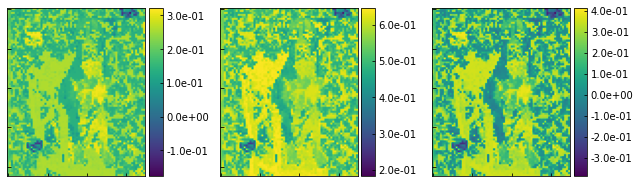

In [24]:
# Visualize the learned embeddings

viz.embedding_maps(nala_encoded_, image)

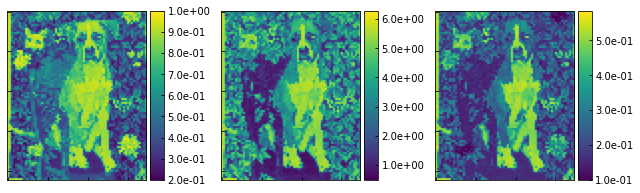

In [25]:
# visualize the actual RGB channels.

viz.embedding_maps(_nala_params.reshape(-1,3), image)

## There is minimal resemblance to the true features

* This is unsurprising because there are no rules that define what the embedding should look like.

# Let's try a bigger model

In [26]:
device = 'cuda'
latent_dim = 12

encoder = Encoder(latent_dim=latent_dim).to(device)
decoder = Decoder(latent_dim=latent_dim).to(device)
model = Autoencoder(encoder, decoder).to(device)

# optimizer

optimizer = optim.Adam(model.parameters(), lr=3e-5)

In [27]:
# views the model

model

Autoencoder(
  (encoder): Encoder(
    (lstm): LSTM(1, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (embedding): Linear(in_features=24, out_features=12, bias=True)
    (relu): ReLU()
  )
  (decoder): Decoder(
    (lstm): LSTM(12, 12, batch_first=True, bidirectional=True)
    (lstm2): LSTM(24, 12, batch_first=True, bidirectional=True)
    (tdd): Conv1d(24, 1, kernel_size=(1,), stride=(1,))
  )
)

In [28]:
# trains the model

torch.manual_seed(0)
nn_util.Train(
    model,
    encoder,
    decoder,
    dataloader,
    optimizer,
    500,
    )

100%|██████████| 20/20 [00:00<00:00, 25.88it/s]


Epoch 0, Train Loss: 0.2180
.............................


100%|██████████| 20/20 [00:00<00:00, 26.87it/s]


Epoch 1, Train Loss: 0.2166
.............................


100%|██████████| 20/20 [00:00<00:00, 26.84it/s]


Epoch 2, Train Loss: 0.2151
.............................


100%|██████████| 20/20 [00:00<00:00, 26.87it/s]


Epoch 3, Train Loss: 0.2145
.............................


100%|██████████| 20/20 [00:00<00:00, 25.88it/s]


Epoch 4, Train Loss: 0.2131
.............................


100%|██████████| 20/20 [00:00<00:00, 26.56it/s]


Epoch 5, Train Loss: 0.2126
.............................


100%|██████████| 20/20 [00:00<00:00, 26.84it/s]


Epoch 6, Train Loss: 0.2120
.............................


100%|██████████| 20/20 [00:00<00:00, 26.61it/s]


Epoch 7, Train Loss: 0.2116
.............................


100%|██████████| 20/20 [00:00<00:00, 26.49it/s]


Epoch 8, Train Loss: 0.2110
.............................


100%|██████████| 20/20 [00:00<00:00, 26.10it/s]


Epoch 9, Train Loss: 0.2106
.............................


100%|██████████| 20/20 [00:00<00:00, 26.53it/s]


Epoch 10, Train Loss: 0.2108
.............................


100%|██████████| 20/20 [00:00<00:00, 26.22it/s]


Epoch 11, Train Loss: 0.2103
.............................


100%|██████████| 20/20 [00:00<00:00, 26.21it/s]


Epoch 12, Train Loss: 0.2105
.............................


100%|██████████| 20/20 [00:00<00:00, 26.54it/s]


Epoch 13, Train Loss: 0.2105
.............................


100%|██████████| 20/20 [00:00<00:00, 26.78it/s]


Epoch 14, Train Loss: 0.2102
.............................


100%|██████████| 20/20 [00:00<00:00, 26.55it/s]


Epoch 15, Train Loss: 0.2101
.............................


100%|██████████| 20/20 [00:00<00:00, 26.59it/s]


Epoch 16, Train Loss: 0.2101
.............................


100%|██████████| 20/20 [00:00<00:00, 26.27it/s]


Epoch 17, Train Loss: 0.2098
.............................


100%|██████████| 20/20 [00:00<00:00, 26.43it/s]


Epoch 18, Train Loss: 0.2102
.............................


100%|██████████| 20/20 [00:00<00:00, 26.63it/s]


Epoch 19, Train Loss: 0.2103
.............................


100%|██████████| 20/20 [00:00<00:00, 26.16it/s]


Epoch 20, Train Loss: 0.2103
.............................


100%|██████████| 20/20 [00:00<00:00, 25.93it/s]


Epoch 21, Train Loss: 0.2099
.............................


100%|██████████| 20/20 [00:00<00:00, 26.52it/s]


Epoch 22, Train Loss: 0.2101
.............................


100%|██████████| 20/20 [00:00<00:00, 26.08it/s]


Epoch 23, Train Loss: 0.2103
.............................


100%|██████████| 20/20 [00:00<00:00, 26.03it/s]


Epoch 24, Train Loss: 0.2104
.............................


100%|██████████| 20/20 [00:00<00:00, 26.21it/s]


Epoch 25, Train Loss: 0.2101
.............................


100%|██████████| 20/20 [00:00<00:00, 25.96it/s]


Epoch 26, Train Loss: 0.2102
.............................


100%|██████████| 20/20 [00:00<00:00, 26.54it/s]


Epoch 27, Train Loss: 0.2102
.............................


100%|██████████| 20/20 [00:00<00:00, 26.35it/s]


Epoch 28, Train Loss: 0.2100
.............................


100%|██████████| 20/20 [00:00<00:00, 26.23it/s]


Epoch 29, Train Loss: 0.2103
.............................


100%|██████████| 20/20 [00:00<00:00, 26.86it/s]


Epoch 30, Train Loss: 0.2103
.............................


100%|██████████| 20/20 [00:00<00:00, 26.10it/s]


Epoch 31, Train Loss: 0.2103
.............................


100%|██████████| 20/20 [00:00<00:00, 26.39it/s]


Epoch 32, Train Loss: 0.2100
.............................


100%|██████████| 20/20 [00:00<00:00, 26.35it/s]


Epoch 33, Train Loss: 0.2102
.............................


100%|██████████| 20/20 [00:00<00:00, 25.56it/s]


Epoch 34, Train Loss: 0.2104
.............................


100%|██████████| 20/20 [00:00<00:00, 26.41it/s]


Epoch 35, Train Loss: 0.2101
.............................


100%|██████████| 20/20 [00:00<00:00, 26.21it/s]


Epoch 36, Train Loss: 0.2101
.............................


100%|██████████| 20/20 [00:00<00:00, 26.53it/s]


Epoch 37, Train Loss: 0.2098
.............................


100%|██████████| 20/20 [00:00<00:00, 26.58it/s]


Epoch 38, Train Loss: 0.2101
.............................


100%|██████████| 20/20 [00:00<00:00, 26.21it/s]


Epoch 39, Train Loss: 0.2104
.............................


100%|██████████| 20/20 [00:00<00:00, 26.27it/s]


Epoch 40, Train Loss: 0.2099
.............................


100%|██████████| 20/20 [00:00<00:00, 26.29it/s]


Epoch 41, Train Loss: 0.2101
.............................


100%|██████████| 20/20 [00:00<00:00, 25.52it/s]


Epoch 42, Train Loss: 0.2100
.............................


100%|██████████| 20/20 [00:00<00:00, 26.16it/s]


Epoch 43, Train Loss: 0.2102
.............................


100%|██████████| 20/20 [00:00<00:00, 26.24it/s]


Epoch 44, Train Loss: 0.2105
.............................


100%|██████████| 20/20 [00:00<00:00, 25.82it/s]


Epoch 45, Train Loss: 0.2100
.............................


100%|██████████| 20/20 [00:00<00:00, 25.98it/s]


Epoch 46, Train Loss: 0.2102
.............................


100%|██████████| 20/20 [00:00<00:00, 25.99it/s]


Epoch 47, Train Loss: 0.2100
.............................


100%|██████████| 20/20 [00:00<00:00, 26.13it/s]


Epoch 48, Train Loss: 0.2097
.............................


100%|██████████| 20/20 [00:00<00:00, 26.23it/s]


Epoch 49, Train Loss: 0.2101
.............................


100%|██████████| 20/20 [00:00<00:00, 26.34it/s]


Epoch 50, Train Loss: 0.2104
.............................


100%|██████████| 20/20 [00:00<00:00, 26.00it/s]


Epoch 51, Train Loss: 0.2103
.............................


100%|██████████| 20/20 [00:00<00:00, 25.98it/s]


Epoch 52, Train Loss: 0.2103
.............................


100%|██████████| 20/20 [00:00<00:00, 25.87it/s]


Epoch 53, Train Loss: 0.2105
.............................


100%|██████████| 20/20 [00:00<00:00, 26.33it/s]


Epoch 54, Train Loss: 0.2105
.............................


100%|██████████| 20/20 [00:00<00:00, 25.92it/s]


Epoch 55, Train Loss: 0.2103
.............................


100%|██████████| 20/20 [00:00<00:00, 26.57it/s]


Epoch 56, Train Loss: 0.2102
.............................


100%|██████████| 20/20 [00:00<00:00, 26.69it/s]


Epoch 57, Train Loss: 0.2100
.............................


100%|██████████| 20/20 [00:00<00:00, 25.93it/s]


Epoch 58, Train Loss: 0.2102
.............................


100%|██████████| 20/20 [00:00<00:00, 26.01it/s]


Epoch 59, Train Loss: 0.2100
.............................


100%|██████████| 20/20 [00:00<00:00, 26.02it/s]


Epoch 60, Train Loss: 0.2105
.............................


100%|██████████| 20/20 [00:00<00:00, 26.16it/s]


Epoch 61, Train Loss: 0.2103
.............................


100%|██████████| 20/20 [00:00<00:00, 26.52it/s]


Epoch 62, Train Loss: 0.2103
.............................


100%|██████████| 20/20 [00:00<00:00, 26.49it/s]


Epoch 63, Train Loss: 0.2105
.............................


100%|██████████| 20/20 [00:00<00:00, 25.98it/s]


Epoch 64, Train Loss: 0.2102
.............................


100%|██████████| 20/20 [00:00<00:00, 26.60it/s]


Epoch 65, Train Loss: 0.2100
.............................


100%|██████████| 20/20 [00:00<00:00, 26.02it/s]


Epoch 66, Train Loss: 0.2100
.............................


100%|██████████| 20/20 [00:00<00:00, 25.83it/s]


Epoch 67, Train Loss: 0.2102
.............................


100%|██████████| 20/20 [00:00<00:00, 26.04it/s]


Epoch 68, Train Loss: 0.2102
.............................


100%|██████████| 20/20 [00:00<00:00, 26.09it/s]


Epoch 69, Train Loss: 0.2100
.............................


100%|██████████| 20/20 [00:00<00:00, 26.29it/s]


Epoch 70, Train Loss: 0.2105
.............................


100%|██████████| 20/20 [00:00<00:00, 25.83it/s]


Epoch 71, Train Loss: 0.2101
.............................


100%|██████████| 20/20 [00:00<00:00, 25.79it/s]


Epoch 72, Train Loss: 0.2103
.............................


100%|██████████| 20/20 [00:00<00:00, 26.18it/s]


Epoch 73, Train Loss: 0.2102
.............................


100%|██████████| 20/20 [00:00<00:00, 26.16it/s]


Epoch 74, Train Loss: 0.2103
.............................


100%|██████████| 20/20 [00:00<00:00, 26.17it/s]


Epoch 75, Train Loss: 0.2097
.............................


100%|██████████| 20/20 [00:00<00:00, 25.73it/s]


Epoch 76, Train Loss: 0.2099
.............................


100%|██████████| 20/20 [00:00<00:00, 26.02it/s]


Epoch 77, Train Loss: 0.2099
.............................


100%|██████████| 20/20 [00:00<00:00, 26.32it/s]


Epoch 78, Train Loss: 0.2099
.............................


100%|██████████| 20/20 [00:00<00:00, 25.82it/s]


Epoch 79, Train Loss: 0.2100
.............................


100%|██████████| 20/20 [00:00<00:00, 25.90it/s]


Epoch 80, Train Loss: 0.2100
.............................


100%|██████████| 20/20 [00:00<00:00, 26.33it/s]


Epoch 81, Train Loss: 0.2098
.............................


100%|██████████| 20/20 [00:00<00:00, 25.60it/s]


Epoch 82, Train Loss: 0.2096
.............................


100%|██████████| 20/20 [00:00<00:00, 26.26it/s]


Epoch 83, Train Loss: 0.2099
.............................


100%|██████████| 20/20 [00:00<00:00, 26.06it/s]


Epoch 84, Train Loss: 0.2093
.............................


100%|██████████| 20/20 [00:00<00:00, 26.06it/s]


Epoch 85, Train Loss: 0.2100
.............................


100%|██████████| 20/20 [00:00<00:00, 26.16it/s]


Epoch 86, Train Loss: 0.2099
.............................


100%|██████████| 20/20 [00:00<00:00, 26.02it/s]


Epoch 87, Train Loss: 0.2097
.............................


100%|██████████| 20/20 [00:00<00:00, 26.49it/s]


Epoch 88, Train Loss: 0.2093
.............................


100%|██████████| 20/20 [00:00<00:00, 26.25it/s]


Epoch 89, Train Loss: 0.2094
.............................


100%|██████████| 20/20 [00:00<00:00, 25.94it/s]


Epoch 90, Train Loss: 0.2092
.............................


100%|██████████| 20/20 [00:00<00:00, 26.51it/s]


Epoch 91, Train Loss: 0.2089
.............................


100%|██████████| 20/20 [00:00<00:00, 26.23it/s]


Epoch 92, Train Loss: 0.2089
.............................


100%|██████████| 20/20 [00:00<00:00, 25.98it/s]


Epoch 93, Train Loss: 0.2093
.............................


100%|██████████| 20/20 [00:00<00:00, 25.95it/s]


Epoch 94, Train Loss: 0.2081
.............................


100%|██████████| 20/20 [00:00<00:00, 26.29it/s]


Epoch 95, Train Loss: 0.2081
.............................


100%|██████████| 20/20 [00:00<00:00, 26.22it/s]


Epoch 96, Train Loss: 0.2076
.............................


100%|██████████| 20/20 [00:00<00:00, 26.03it/s]


Epoch 97, Train Loss: 0.2066
.............................


100%|██████████| 20/20 [00:00<00:00, 26.24it/s]


Epoch 98, Train Loss: 0.2057
.............................


100%|██████████| 20/20 [00:00<00:00, 25.78it/s]


Epoch 99, Train Loss: 0.2044
.............................


100%|██████████| 20/20 [00:00<00:00, 26.33it/s]


Epoch 100, Train Loss: 0.2031
.............................


100%|██████████| 20/20 [00:00<00:00, 25.87it/s]


Epoch 101, Train Loss: 0.2019
.............................


100%|██████████| 20/20 [00:00<00:00, 26.18it/s]


Epoch 102, Train Loss: 0.2013
.............................


100%|██████████| 20/20 [00:00<00:00, 26.10it/s]


Epoch 103, Train Loss: 0.2010
.............................


100%|██████████| 20/20 [00:00<00:00, 25.94it/s]


Epoch 104, Train Loss: 0.2008
.............................


100%|██████████| 20/20 [00:00<00:00, 26.10it/s]


Epoch 105, Train Loss: 0.2007
.............................


100%|██████████| 20/20 [00:00<00:00, 25.98it/s]


Epoch 106, Train Loss: 0.2005
.............................


100%|██████████| 20/20 [00:00<00:00, 25.87it/s]


Epoch 107, Train Loss: 0.2002
.............................


100%|██████████| 20/20 [00:00<00:00, 26.31it/s]


Epoch 108, Train Loss: 0.2003
.............................


100%|██████████| 20/20 [00:00<00:00, 26.10it/s]


Epoch 109, Train Loss: 0.1999
.............................


100%|██████████| 20/20 [00:00<00:00, 26.07it/s]


Epoch 110, Train Loss: 0.1998
.............................


100%|██████████| 20/20 [00:00<00:00, 25.90it/s]


Epoch 111, Train Loss: 0.1998
.............................


100%|██████████| 20/20 [00:00<00:00, 25.43it/s]


Epoch 112, Train Loss: 0.1996
.............................


100%|██████████| 20/20 [00:00<00:00, 26.55it/s]


Epoch 113, Train Loss: 0.1996
.............................


100%|██████████| 20/20 [00:00<00:00, 25.79it/s]


Epoch 114, Train Loss: 0.1993
.............................


100%|██████████| 20/20 [00:00<00:00, 26.05it/s]


Epoch 115, Train Loss: 0.1990
.............................


100%|██████████| 20/20 [00:00<00:00, 26.08it/s]


Epoch 116, Train Loss: 0.1990
.............................


100%|██████████| 20/20 [00:00<00:00, 25.72it/s]


Epoch 117, Train Loss: 0.1990
.............................


100%|██████████| 20/20 [00:00<00:00, 26.38it/s]


Epoch 118, Train Loss: 0.1989
.............................


100%|██████████| 20/20 [00:00<00:00, 25.70it/s]


Epoch 119, Train Loss: 0.1987
.............................


100%|██████████| 20/20 [00:00<00:00, 25.53it/s]


Epoch 120, Train Loss: 0.1980
.............................


100%|██████████| 20/20 [00:00<00:00, 26.05it/s]


Epoch 121, Train Loss: 0.1982
.............................


100%|██████████| 20/20 [00:00<00:00, 25.84it/s]


Epoch 122, Train Loss: 0.1978
.............................


100%|██████████| 20/20 [00:00<00:00, 25.72it/s]


Epoch 123, Train Loss: 0.1973
.............................


100%|██████████| 20/20 [00:00<00:00, 25.90it/s]


Epoch 124, Train Loss: 0.1965
.............................


100%|██████████| 20/20 [00:00<00:00, 25.58it/s]


Epoch 125, Train Loss: 0.1959
.............................


100%|██████████| 20/20 [00:00<00:00, 25.78it/s]


Epoch 126, Train Loss: 0.1950
.............................


100%|██████████| 20/20 [00:00<00:00, 25.82it/s]


Epoch 127, Train Loss: 0.1941
.............................


100%|██████████| 20/20 [00:00<00:00, 25.97it/s]


Epoch 128, Train Loss: 0.1933
.............................


100%|██████████| 20/20 [00:00<00:00, 26.37it/s]


Epoch 129, Train Loss: 0.1921
.............................


100%|██████████| 20/20 [00:00<00:00, 26.25it/s]


Epoch 130, Train Loss: 0.1916
.............................


100%|██████████| 20/20 [00:00<00:00, 25.89it/s]


Epoch 131, Train Loss: 0.1907
.............................


100%|██████████| 20/20 [00:00<00:00, 26.17it/s]


Epoch 132, Train Loss: 0.1904
.............................


100%|██████████| 20/20 [00:00<00:00, 25.86it/s]


Epoch 133, Train Loss: 0.1907
.............................


100%|██████████| 20/20 [00:00<00:00, 26.13it/s]


Epoch 134, Train Loss: 0.1898
.............................


100%|██████████| 20/20 [00:00<00:00, 26.38it/s]


Epoch 135, Train Loss: 0.1895
.............................


100%|██████████| 20/20 [00:00<00:00, 25.82it/s]


Epoch 136, Train Loss: 0.1889
.............................


100%|██████████| 20/20 [00:00<00:00, 26.29it/s]


Epoch 137, Train Loss: 0.1889
.............................


100%|██████████| 20/20 [00:00<00:00, 25.41it/s]


Epoch 138, Train Loss: 0.1886
.............................


100%|██████████| 20/20 [00:00<00:00, 26.02it/s]


Epoch 139, Train Loss: 0.1878
.............................


100%|██████████| 20/20 [00:00<00:00, 26.02it/s]


Epoch 140, Train Loss: 0.1878
.............................


100%|██████████| 20/20 [00:00<00:00, 25.96it/s]


Epoch 141, Train Loss: 0.1869
.............................


100%|██████████| 20/20 [00:00<00:00, 26.44it/s]


Epoch 142, Train Loss: 0.1860
.............................


100%|██████████| 20/20 [00:00<00:00, 25.88it/s]


Epoch 143, Train Loss: 0.1856
.............................


100%|██████████| 20/20 [00:00<00:00, 26.04it/s]


Epoch 144, Train Loss: 0.1841
.............................


100%|██████████| 20/20 [00:00<00:00, 25.98it/s]


Epoch 145, Train Loss: 0.1826
.............................


100%|██████████| 20/20 [00:00<00:00, 25.70it/s]


Epoch 146, Train Loss: 0.1815
.............................


100%|██████████| 20/20 [00:00<00:00, 26.01it/s]


Epoch 147, Train Loss: 0.1807
.............................


100%|██████████| 20/20 [00:00<00:00, 25.71it/s]


Epoch 148, Train Loss: 0.1800
.............................


100%|██████████| 20/20 [00:00<00:00, 25.45it/s]


Epoch 149, Train Loss: 0.1799
.............................


100%|██████████| 20/20 [00:00<00:00, 26.05it/s]


Epoch 150, Train Loss: 0.1793
.............................


100%|██████████| 20/20 [00:00<00:00, 25.68it/s]


Epoch 151, Train Loss: 0.1798
.............................


100%|██████████| 20/20 [00:00<00:00, 25.95it/s]


Epoch 152, Train Loss: 0.1801
.............................


100%|██████████| 20/20 [00:00<00:00, 25.92it/s]


Epoch 153, Train Loss: 0.1790
.............................


100%|██████████| 20/20 [00:00<00:00, 25.67it/s]


Epoch 154, Train Loss: 0.1791
.............................


100%|██████████| 20/20 [00:00<00:00, 25.91it/s]


Epoch 155, Train Loss: 0.1789
.............................


100%|██████████| 20/20 [00:00<00:00, 25.82it/s]


Epoch 156, Train Loss: 0.1783
.............................


100%|██████████| 20/20 [00:00<00:00, 25.77it/s]


Epoch 157, Train Loss: 0.1785
.............................


100%|██████████| 20/20 [00:00<00:00, 25.79it/s]


Epoch 158, Train Loss: 0.1787
.............................


100%|██████████| 20/20 [00:00<00:00, 25.55it/s]


Epoch 159, Train Loss: 0.1788
.............................


100%|██████████| 20/20 [00:00<00:00, 26.05it/s]


Epoch 160, Train Loss: 0.1784
.............................


100%|██████████| 20/20 [00:00<00:00, 26.04it/s]


Epoch 161, Train Loss: 0.1783
.............................


100%|██████████| 20/20 [00:00<00:00, 25.69it/s]


Epoch 162, Train Loss: 0.1783
.............................


100%|██████████| 20/20 [00:00<00:00, 26.28it/s]


Epoch 163, Train Loss: 0.1784
.............................


100%|██████████| 20/20 [00:00<00:00, 25.91it/s]


Epoch 164, Train Loss: 0.1781
.............................


100%|██████████| 20/20 [00:00<00:00, 25.82it/s]


Epoch 165, Train Loss: 0.1780
.............................


100%|██████████| 20/20 [00:00<00:00, 26.12it/s]


Epoch 166, Train Loss: 0.1777
.............................


100%|██████████| 20/20 [00:00<00:00, 25.87it/s]


Epoch 167, Train Loss: 0.1778
.............................


100%|██████████| 20/20 [00:00<00:00, 25.94it/s]


Epoch 168, Train Loss: 0.1780
.............................


100%|██████████| 20/20 [00:00<00:00, 25.91it/s]


Epoch 169, Train Loss: 0.1777
.............................


100%|██████████| 20/20 [00:00<00:00, 26.43it/s]


Epoch 170, Train Loss: 0.1776
.............................


100%|██████████| 20/20 [00:00<00:00, 25.74it/s]


Epoch 171, Train Loss: 0.1778
.............................


100%|██████████| 20/20 [00:00<00:00, 25.66it/s]


Epoch 172, Train Loss: 0.1778
.............................


100%|██████████| 20/20 [00:00<00:00, 25.57it/s]


Epoch 173, Train Loss: 0.1779
.............................


100%|██████████| 20/20 [00:00<00:00, 25.43it/s]


Epoch 174, Train Loss: 0.1774
.............................


100%|██████████| 20/20 [00:00<00:00, 26.02it/s]


Epoch 175, Train Loss: 0.1775
.............................


100%|██████████| 20/20 [00:00<00:00, 26.32it/s]


Epoch 176, Train Loss: 0.1774
.............................


100%|██████████| 20/20 [00:00<00:00, 26.52it/s]


Epoch 177, Train Loss: 0.1774
.............................


100%|██████████| 20/20 [00:00<00:00, 26.01it/s]


Epoch 178, Train Loss: 0.1769
.............................


100%|██████████| 20/20 [00:00<00:00, 26.19it/s]


Epoch 179, Train Loss: 0.1776
.............................


100%|██████████| 20/20 [00:00<00:00, 25.74it/s]


Epoch 180, Train Loss: 0.1768
.............................


100%|██████████| 20/20 [00:00<00:00, 25.81it/s]


Epoch 181, Train Loss: 0.1769
.............................


100%|██████████| 20/20 [00:00<00:00, 26.08it/s]


Epoch 182, Train Loss: 0.1773
.............................


100%|██████████| 20/20 [00:00<00:00, 25.88it/s]


Epoch 183, Train Loss: 0.1771
.............................


100%|██████████| 20/20 [00:00<00:00, 26.07it/s]


Epoch 184, Train Loss: 0.1772
.............................


100%|██████████| 20/20 [00:00<00:00, 25.90it/s]


Epoch 185, Train Loss: 0.1769
.............................


100%|██████████| 20/20 [00:00<00:00, 25.88it/s]


Epoch 186, Train Loss: 0.1771
.............................


100%|██████████| 20/20 [00:00<00:00, 26.04it/s]


Epoch 187, Train Loss: 0.1766
.............................


100%|██████████| 20/20 [00:00<00:00, 25.79it/s]


Epoch 188, Train Loss: 0.1767
.............................


100%|██████████| 20/20 [00:00<00:00, 26.12it/s]


Epoch 189, Train Loss: 0.1768
.............................


100%|██████████| 20/20 [00:00<00:00, 25.52it/s]


Epoch 190, Train Loss: 0.1765
.............................


100%|██████████| 20/20 [00:00<00:00, 25.85it/s]


Epoch 191, Train Loss: 0.1764
.............................


100%|██████████| 20/20 [00:00<00:00, 25.88it/s]


Epoch 192, Train Loss: 0.1761
.............................


100%|██████████| 20/20 [00:00<00:00, 26.06it/s]


Epoch 193, Train Loss: 0.1765
.............................


100%|██████████| 20/20 [00:00<00:00, 25.76it/s]


Epoch 194, Train Loss: 0.1760
.............................


100%|██████████| 20/20 [00:00<00:00, 25.66it/s]


Epoch 195, Train Loss: 0.1759
.............................


100%|██████████| 20/20 [00:00<00:00, 25.74it/s]


Epoch 196, Train Loss: 0.1761
.............................


100%|██████████| 20/20 [00:00<00:00, 25.90it/s]


Epoch 197, Train Loss: 0.1759
.............................


100%|██████████| 20/20 [00:00<00:00, 25.91it/s]


Epoch 198, Train Loss: 0.1759
.............................


100%|██████████| 20/20 [00:00<00:00, 26.18it/s]


Epoch 199, Train Loss: 0.1761
.............................


100%|██████████| 20/20 [00:00<00:00, 25.94it/s]


Epoch 200, Train Loss: 0.1757
.............................


100%|██████████| 20/20 [00:00<00:00, 25.74it/s]


Epoch 201, Train Loss: 0.1756
.............................


100%|██████████| 20/20 [00:00<00:00, 25.93it/s]


Epoch 202, Train Loss: 0.1757
.............................


100%|██████████| 20/20 [00:00<00:00, 25.82it/s]


Epoch 203, Train Loss: 0.1756
.............................


100%|██████████| 20/20 [00:00<00:00, 25.74it/s]


Epoch 204, Train Loss: 0.1758
.............................


100%|██████████| 20/20 [00:00<00:00, 25.90it/s]


Epoch 205, Train Loss: 0.1752
.............................


100%|██████████| 20/20 [00:00<00:00, 25.46it/s]


Epoch 206, Train Loss: 0.1747
.............................


100%|██████████| 20/20 [00:00<00:00, 26.25it/s]


Epoch 207, Train Loss: 0.1745
.............................


100%|██████████| 20/20 [00:00<00:00, 25.76it/s]


Epoch 208, Train Loss: 0.1747
.............................


100%|██████████| 20/20 [00:00<00:00, 25.83it/s]


Epoch 209, Train Loss: 0.1744
.............................


100%|██████████| 20/20 [00:00<00:00, 26.11it/s]


Epoch 210, Train Loss: 0.1742
.............................


100%|██████████| 20/20 [00:00<00:00, 25.57it/s]


Epoch 211, Train Loss: 0.1738
.............................


100%|██████████| 20/20 [00:00<00:00, 26.03it/s]


Epoch 212, Train Loss: 0.1741
.............................


100%|██████████| 20/20 [00:00<00:00, 26.29it/s]


Epoch 213, Train Loss: 0.1737
.............................


100%|██████████| 20/20 [00:00<00:00, 26.12it/s]


Epoch 214, Train Loss: 0.1731
.............................


100%|██████████| 20/20 [00:00<00:00, 26.11it/s]


Epoch 215, Train Loss: 0.1725
.............................


100%|██████████| 20/20 [00:00<00:00, 26.14it/s]


Epoch 216, Train Loss: 0.1726
.............................


100%|██████████| 20/20 [00:00<00:00, 25.94it/s]


Epoch 217, Train Loss: 0.1717
.............................


100%|██████████| 20/20 [00:00<00:00, 26.42it/s]


Epoch 218, Train Loss: 0.1707
.............................


100%|██████████| 20/20 [00:00<00:00, 26.20it/s]


Epoch 219, Train Loss: 0.1699
.............................


100%|██████████| 20/20 [00:00<00:00, 25.61it/s]


Epoch 220, Train Loss: 0.1699
.............................


100%|██████████| 20/20 [00:00<00:00, 25.67it/s]


Epoch 221, Train Loss: 0.1683
.............................


100%|██████████| 20/20 [00:00<00:00, 26.20it/s]


Epoch 222, Train Loss: 0.1678
.............................


100%|██████████| 20/20 [00:00<00:00, 26.00it/s]


Epoch 223, Train Loss: 0.1666
.............................


100%|██████████| 20/20 [00:00<00:00, 25.77it/s]


Epoch 224, Train Loss: 0.1662
.............................


100%|██████████| 20/20 [00:00<00:00, 25.73it/s]


Epoch 225, Train Loss: 0.1652
.............................


100%|██████████| 20/20 [00:00<00:00, 26.29it/s]


Epoch 226, Train Loss: 0.1644
.............................


100%|██████████| 20/20 [00:00<00:00, 25.86it/s]


Epoch 227, Train Loss: 0.1643
.............................


100%|██████████| 20/20 [00:00<00:00, 25.88it/s]


Epoch 228, Train Loss: 0.1629
.............................


100%|██████████| 20/20 [00:00<00:00, 26.15it/s]


Epoch 229, Train Loss: 0.1624
.............................


100%|██████████| 20/20 [00:00<00:00, 25.66it/s]


Epoch 230, Train Loss: 0.1618
.............................


100%|██████████| 20/20 [00:00<00:00, 25.78it/s]


Epoch 231, Train Loss: 0.1607
.............................


100%|██████████| 20/20 [00:00<00:00, 25.76it/s]


Epoch 232, Train Loss: 0.1602
.............................


100%|██████████| 20/20 [00:00<00:00, 25.45it/s]


Epoch 233, Train Loss: 0.1598
.............................


100%|██████████| 20/20 [00:00<00:00, 25.70it/s]


Epoch 234, Train Loss: 0.1592
.............................


100%|██████████| 20/20 [00:00<00:00, 25.61it/s]


Epoch 235, Train Loss: 0.1593
.............................


100%|██████████| 20/20 [00:00<00:00, 25.51it/s]


Epoch 236, Train Loss: 0.1587
.............................


100%|██████████| 20/20 [00:00<00:00, 25.82it/s]


Epoch 237, Train Loss: 0.1582
.............................


100%|██████████| 20/20 [00:00<00:00, 25.41it/s]


Epoch 238, Train Loss: 0.1574
.............................


100%|██████████| 20/20 [00:00<00:00, 25.85it/s]


Epoch 239, Train Loss: 0.1576
.............................


100%|██████████| 20/20 [00:00<00:00, 26.16it/s]


Epoch 240, Train Loss: 0.1579
.............................


100%|██████████| 20/20 [00:00<00:00, 25.78it/s]


Epoch 241, Train Loss: 0.1577
.............................


100%|██████████| 20/20 [00:00<00:00, 25.72it/s]


Epoch 242, Train Loss: 0.1570
.............................


100%|██████████| 20/20 [00:00<00:00, 25.55it/s]


Epoch 243, Train Loss: 0.1565
.............................


100%|██████████| 20/20 [00:00<00:00, 26.13it/s]


Epoch 244, Train Loss: 0.1566
.............................


100%|██████████| 20/20 [00:00<00:00, 25.49it/s]


Epoch 245, Train Loss: 0.1559
.............................


100%|██████████| 20/20 [00:00<00:00, 25.98it/s]


Epoch 246, Train Loss: 0.1561
.............................


100%|██████████| 20/20 [00:00<00:00, 25.90it/s]


Epoch 247, Train Loss: 0.1557
.............................


100%|██████████| 20/20 [00:00<00:00, 25.65it/s]


Epoch 248, Train Loss: 0.1556
.............................


100%|██████████| 20/20 [00:00<00:00, 25.79it/s]


Epoch 249, Train Loss: 0.1554
.............................


100%|██████████| 20/20 [00:00<00:00, 25.84it/s]


Epoch 250, Train Loss: 0.1549
.............................


100%|██████████| 20/20 [00:00<00:00, 25.76it/s]


Epoch 251, Train Loss: 0.1548
.............................


100%|██████████| 20/20 [00:00<00:00, 25.86it/s]


Epoch 252, Train Loss: 0.1550
.............................


100%|██████████| 20/20 [00:00<00:00, 26.00it/s]


Epoch 253, Train Loss: 0.1549
.............................


100%|██████████| 20/20 [00:00<00:00, 25.91it/s]


Epoch 254, Train Loss: 0.1550
.............................


100%|██████████| 20/20 [00:00<00:00, 25.47it/s]


Epoch 255, Train Loss: 0.1548
.............................


100%|██████████| 20/20 [00:00<00:00, 25.56it/s]


Epoch 256, Train Loss: 0.1548
.............................


100%|██████████| 20/20 [00:00<00:00, 25.84it/s]


Epoch 257, Train Loss: 0.1544
.............................


100%|██████████| 20/20 [00:00<00:00, 25.61it/s]


Epoch 258, Train Loss: 0.1545
.............................


100%|██████████| 20/20 [00:00<00:00, 25.88it/s]


Epoch 259, Train Loss: 0.1541
.............................


100%|██████████| 20/20 [00:00<00:00, 26.52it/s]


Epoch 260, Train Loss: 0.1542
.............................


100%|██████████| 20/20 [00:00<00:00, 25.48it/s]


Epoch 261, Train Loss: 0.1538
.............................


100%|██████████| 20/20 [00:00<00:00, 25.85it/s]


Epoch 262, Train Loss: 0.1538
.............................


100%|██████████| 20/20 [00:00<00:00, 25.50it/s]


Epoch 263, Train Loss: 0.1537
.............................


100%|██████████| 20/20 [00:00<00:00, 25.72it/s]


Epoch 264, Train Loss: 0.1541
.............................


100%|██████████| 20/20 [00:00<00:00, 25.84it/s]


Epoch 265, Train Loss: 0.1540
.............................


100%|██████████| 20/20 [00:00<00:00, 25.12it/s]


Epoch 266, Train Loss: 0.1538
.............................


100%|██████████| 20/20 [00:00<00:00, 25.37it/s]


Epoch 267, Train Loss: 0.1536
.............................


100%|██████████| 20/20 [00:00<00:00, 25.16it/s]


Epoch 268, Train Loss: 0.1535
.............................


100%|██████████| 20/20 [00:00<00:00, 25.60it/s]


Epoch 269, Train Loss: 0.1529
.............................


100%|██████████| 20/20 [00:00<00:00, 25.72it/s]


Epoch 270, Train Loss: 0.1533
.............................


100%|██████████| 20/20 [00:00<00:00, 25.19it/s]


Epoch 271, Train Loss: 0.1531
.............................


100%|██████████| 20/20 [00:00<00:00, 25.35it/s]


Epoch 272, Train Loss: 0.1531
.............................


100%|██████████| 20/20 [00:00<00:00, 25.64it/s]


Epoch 273, Train Loss: 0.1531
.............................


100%|██████████| 20/20 [00:00<00:00, 25.63it/s]


Epoch 274, Train Loss: 0.1533
.............................


100%|██████████| 20/20 [00:00<00:00, 25.68it/s]


Epoch 275, Train Loss: 0.1532
.............................


100%|██████████| 20/20 [00:00<00:00, 25.24it/s]


Epoch 276, Train Loss: 0.1530
.............................


100%|██████████| 20/20 [00:00<00:00, 25.66it/s]


Epoch 277, Train Loss: 0.1528
.............................


100%|██████████| 20/20 [00:00<00:00, 25.88it/s]


Epoch 278, Train Loss: 0.1527
.............................


100%|██████████| 20/20 [00:00<00:00, 25.39it/s]


Epoch 279, Train Loss: 0.1527
.............................


100%|██████████| 20/20 [00:00<00:00, 25.81it/s]


Epoch 280, Train Loss: 0.1527
.............................


100%|██████████| 20/20 [00:00<00:00, 25.67it/s]


Epoch 281, Train Loss: 0.1525
.............................


100%|██████████| 20/20 [00:00<00:00, 25.45it/s]


Epoch 282, Train Loss: 0.1525
.............................


100%|██████████| 20/20 [00:00<00:00, 25.80it/s]


Epoch 283, Train Loss: 0.1523
.............................


100%|██████████| 20/20 [00:00<00:00, 25.63it/s]


Epoch 284, Train Loss: 0.1521
.............................


100%|██████████| 20/20 [00:00<00:00, 25.91it/s]


Epoch 285, Train Loss: 0.1526
.............................


100%|██████████| 20/20 [00:00<00:00, 25.48it/s]


Epoch 286, Train Loss: 0.1524
.............................


100%|██████████| 20/20 [00:00<00:00, 25.37it/s]


Epoch 287, Train Loss: 0.1522
.............................


100%|██████████| 20/20 [00:00<00:00, 25.87it/s]


Epoch 288, Train Loss: 0.1520
.............................


100%|██████████| 20/20 [00:00<00:00, 25.49it/s]


Epoch 289, Train Loss: 0.1522
.............................


100%|██████████| 20/20 [00:00<00:00, 25.31it/s]


Epoch 290, Train Loss: 0.1517
.............................


100%|██████████| 20/20 [00:00<00:00, 25.95it/s]


Epoch 291, Train Loss: 0.1518
.............................


100%|██████████| 20/20 [00:00<00:00, 25.73it/s]


Epoch 292, Train Loss: 0.1517
.............................


100%|██████████| 20/20 [00:00<00:00, 25.80it/s]


Epoch 293, Train Loss: 0.1519
.............................


100%|██████████| 20/20 [00:00<00:00, 25.72it/s]


Epoch 294, Train Loss: 0.1518
.............................


100%|██████████| 20/20 [00:00<00:00, 25.85it/s]


Epoch 295, Train Loss: 0.1515
.............................


100%|██████████| 20/20 [00:00<00:00, 25.87it/s]


Epoch 296, Train Loss: 0.1515
.............................


100%|██████████| 20/20 [00:00<00:00, 25.65it/s]


Epoch 297, Train Loss: 0.1517
.............................


100%|██████████| 20/20 [00:00<00:00, 26.24it/s]


Epoch 298, Train Loss: 0.1517
.............................


100%|██████████| 20/20 [00:00<00:00, 25.78it/s]


Epoch 299, Train Loss: 0.1520
.............................


100%|██████████| 20/20 [00:00<00:00, 25.48it/s]


Epoch 300, Train Loss: 0.1513
.............................


100%|██████████| 20/20 [00:00<00:00, 26.11it/s]


Epoch 301, Train Loss: 0.1517
.............................


100%|██████████| 20/20 [00:00<00:00, 25.96it/s]


Epoch 302, Train Loss: 0.1515
.............................


100%|██████████| 20/20 [00:00<00:00, 25.82it/s]


Epoch 303, Train Loss: 0.1515
.............................


100%|██████████| 20/20 [00:00<00:00, 25.73it/s]


Epoch 304, Train Loss: 0.1515
.............................


100%|██████████| 20/20 [00:00<00:00, 25.37it/s]


Epoch 305, Train Loss: 0.1514
.............................


100%|██████████| 20/20 [00:00<00:00, 25.44it/s]


Epoch 306, Train Loss: 0.1508
.............................


100%|██████████| 20/20 [00:00<00:00, 25.77it/s]


Epoch 307, Train Loss: 0.1512
.............................


100%|██████████| 20/20 [00:00<00:00, 25.62it/s]


Epoch 308, Train Loss: 0.1514
.............................


100%|██████████| 20/20 [00:00<00:00, 25.14it/s]


Epoch 309, Train Loss: 0.1514
.............................


100%|██████████| 20/20 [00:00<00:00, 25.35it/s]


Epoch 310, Train Loss: 0.1511
.............................


100%|██████████| 20/20 [00:00<00:00, 25.55it/s]


Epoch 311, Train Loss: 0.1512
.............................


100%|██████████| 20/20 [00:00<00:00, 25.87it/s]


Epoch 312, Train Loss: 0.1510
.............................


100%|██████████| 20/20 [00:00<00:00, 25.64it/s]


Epoch 313, Train Loss: 0.1508
.............................


100%|██████████| 20/20 [00:00<00:00, 25.86it/s]


Epoch 314, Train Loss: 0.1507
.............................


100%|██████████| 20/20 [00:00<00:00, 25.76it/s]


Epoch 315, Train Loss: 0.1507
.............................


100%|██████████| 20/20 [00:00<00:00, 25.44it/s]


Epoch 316, Train Loss: 0.1510
.............................


100%|██████████| 20/20 [00:00<00:00, 26.03it/s]


Epoch 317, Train Loss: 0.1507
.............................


100%|██████████| 20/20 [00:00<00:00, 25.77it/s]


Epoch 318, Train Loss: 0.1506
.............................


100%|██████████| 20/20 [00:00<00:00, 25.88it/s]


Epoch 319, Train Loss: 0.1506
.............................


100%|██████████| 20/20 [00:00<00:00, 25.68it/s]


Epoch 320, Train Loss: 0.1507
.............................


100%|██████████| 20/20 [00:00<00:00, 25.34it/s]


Epoch 321, Train Loss: 0.1509
.............................


100%|██████████| 20/20 [00:00<00:00, 25.72it/s]


Epoch 322, Train Loss: 0.1506
.............................


100%|██████████| 20/20 [00:00<00:00, 25.85it/s]


Epoch 323, Train Loss: 0.1506
.............................


100%|██████████| 20/20 [00:00<00:00, 25.35it/s]


Epoch 324, Train Loss: 0.1505
.............................


100%|██████████| 20/20 [00:00<00:00, 25.80it/s]


Epoch 325, Train Loss: 0.1504
.............................


100%|██████████| 20/20 [00:00<00:00, 25.78it/s]


Epoch 326, Train Loss: 0.1504
.............................


100%|██████████| 20/20 [00:00<00:00, 25.49it/s]


Epoch 327, Train Loss: 0.1504
.............................


100%|██████████| 20/20 [00:00<00:00, 26.40it/s]


Epoch 328, Train Loss: 0.1500
.............................


100%|██████████| 20/20 [00:00<00:00, 25.62it/s]


Epoch 329, Train Loss: 0.1506
.............................


100%|██████████| 20/20 [00:00<00:00, 26.01it/s]


Epoch 330, Train Loss: 0.1501
.............................


100%|██████████| 20/20 [00:00<00:00, 25.47it/s]


Epoch 331, Train Loss: 0.1503
.............................


100%|██████████| 20/20 [00:00<00:00, 25.31it/s]


Epoch 332, Train Loss: 0.1503
.............................


100%|██████████| 20/20 [00:00<00:00, 25.70it/s]


Epoch 333, Train Loss: 0.1502
.............................


100%|██████████| 20/20 [00:00<00:00, 25.13it/s]


Epoch 334, Train Loss: 0.1498
.............................


100%|██████████| 20/20 [00:00<00:00, 25.68it/s]


Epoch 335, Train Loss: 0.1503
.............................


100%|██████████| 20/20 [00:00<00:00, 25.66it/s]


Epoch 336, Train Loss: 0.1499
.............................


100%|██████████| 20/20 [00:00<00:00, 25.54it/s]


Epoch 337, Train Loss: 0.1495
.............................


100%|██████████| 20/20 [00:00<00:00, 26.26it/s]


Epoch 338, Train Loss: 0.1499
.............................


100%|██████████| 20/20 [00:00<00:00, 25.31it/s]


Epoch 339, Train Loss: 0.1501
.............................


100%|██████████| 20/20 [00:00<00:00, 25.48it/s]


Epoch 340, Train Loss: 0.1499
.............................


100%|██████████| 20/20 [00:00<00:00, 25.55it/s]


Epoch 341, Train Loss: 0.1495
.............................


100%|██████████| 20/20 [00:00<00:00, 25.69it/s]


Epoch 342, Train Loss: 0.1493
.............................


100%|██████████| 20/20 [00:00<00:00, 26.18it/s]


Epoch 343, Train Loss: 0.1493
.............................


100%|██████████| 20/20 [00:00<00:00, 25.67it/s]


Epoch 344, Train Loss: 0.1496
.............................


100%|██████████| 20/20 [00:00<00:00, 25.56it/s]


Epoch 345, Train Loss: 0.1494
.............................


100%|██████████| 20/20 [00:00<00:00, 25.78it/s]


Epoch 346, Train Loss: 0.1496
.............................


100%|██████████| 20/20 [00:00<00:00, 25.16it/s]


Epoch 347, Train Loss: 0.1501
.............................


100%|██████████| 20/20 [00:00<00:00, 25.78it/s]


Epoch 348, Train Loss: 0.1490
.............................


100%|██████████| 20/20 [00:00<00:00, 25.85it/s]


Epoch 349, Train Loss: 0.1495
.............................


100%|██████████| 20/20 [00:00<00:00, 25.49it/s]


Epoch 350, Train Loss: 0.1495
.............................


100%|██████████| 20/20 [00:00<00:00, 25.40it/s]


Epoch 351, Train Loss: 0.1496
.............................


100%|██████████| 20/20 [00:00<00:00, 25.37it/s]


Epoch 352, Train Loss: 0.1491
.............................


100%|██████████| 20/20 [00:00<00:00, 25.46it/s]


Epoch 353, Train Loss: 0.1495
.............................


100%|██████████| 20/20 [00:00<00:00, 25.50it/s]


Epoch 354, Train Loss: 0.1495
.............................


100%|██████████| 20/20 [00:00<00:00, 25.50it/s]


Epoch 355, Train Loss: 0.1495
.............................


100%|██████████| 20/20 [00:00<00:00, 25.84it/s]


Epoch 356, Train Loss: 0.1493
.............................


100%|██████████| 20/20 [00:00<00:00, 25.57it/s]


Epoch 357, Train Loss: 0.1490
.............................


100%|██████████| 20/20 [00:00<00:00, 25.32it/s]


Epoch 358, Train Loss: 0.1491
.............................


100%|██████████| 20/20 [00:00<00:00, 25.61it/s]


Epoch 359, Train Loss: 0.1489
.............................


100%|██████████| 20/20 [00:00<00:00, 25.91it/s]


Epoch 360, Train Loss: 0.1489
.............................


100%|██████████| 20/20 [00:00<00:00, 25.90it/s]


Epoch 361, Train Loss: 0.1490
.............................


100%|██████████| 20/20 [00:00<00:00, 26.09it/s]


Epoch 362, Train Loss: 0.1490
.............................


100%|██████████| 20/20 [00:00<00:00, 25.38it/s]


Epoch 363, Train Loss: 0.1487
.............................


100%|██████████| 20/20 [00:00<00:00, 25.50it/s]


Epoch 364, Train Loss: 0.1490
.............................


100%|██████████| 20/20 [00:00<00:00, 25.89it/s]


Epoch 365, Train Loss: 0.1489
.............................


100%|██████████| 20/20 [00:00<00:00, 25.37it/s]


Epoch 366, Train Loss: 0.1488
.............................


100%|██████████| 20/20 [00:00<00:00, 25.89it/s]


Epoch 367, Train Loss: 0.1485
.............................


100%|██████████| 20/20 [00:00<00:00, 25.58it/s]


Epoch 368, Train Loss: 0.1489
.............................


100%|██████████| 20/20 [00:00<00:00, 25.80it/s]


Epoch 369, Train Loss: 0.1487
.............................


100%|██████████| 20/20 [00:00<00:00, 26.21it/s]


Epoch 370, Train Loss: 0.1489
.............................


100%|██████████| 20/20 [00:00<00:00, 25.30it/s]


Epoch 371, Train Loss: 0.1485
.............................


100%|██████████| 20/20 [00:00<00:00, 25.74it/s]


Epoch 372, Train Loss: 0.1485
.............................


100%|██████████| 20/20 [00:00<00:00, 25.83it/s]


Epoch 373, Train Loss: 0.1488
.............................


100%|██████████| 20/20 [00:00<00:00, 25.54it/s]


Epoch 374, Train Loss: 0.1487
.............................


100%|██████████| 20/20 [00:00<00:00, 25.87it/s]


Epoch 375, Train Loss: 0.1481
.............................


100%|██████████| 20/20 [00:00<00:00, 25.47it/s]


Epoch 376, Train Loss: 0.1485
.............................


100%|██████████| 20/20 [00:00<00:00, 25.58it/s]


Epoch 377, Train Loss: 0.1482
.............................


100%|██████████| 20/20 [00:00<00:00, 26.20it/s]


Epoch 378, Train Loss: 0.1485
.............................


100%|██████████| 20/20 [00:00<00:00, 26.02it/s]


Epoch 379, Train Loss: 0.1483
.............................


100%|██████████| 20/20 [00:00<00:00, 25.95it/s]


Epoch 380, Train Loss: 0.1485
.............................


100%|██████████| 20/20 [00:00<00:00, 26.63it/s]


Epoch 381, Train Loss: 0.1477
.............................


100%|██████████| 20/20 [00:00<00:00, 25.25it/s]


Epoch 382, Train Loss: 0.1483
.............................


100%|██████████| 20/20 [00:00<00:00, 25.88it/s]


Epoch 383, Train Loss: 0.1483
.............................


100%|██████████| 20/20 [00:00<00:00, 25.63it/s]


Epoch 384, Train Loss: 0.1485
.............................


100%|██████████| 20/20 [00:00<00:00, 25.40it/s]


Epoch 385, Train Loss: 0.1483
.............................


100%|██████████| 20/20 [00:00<00:00, 25.60it/s]


Epoch 386, Train Loss: 0.1480
.............................


100%|██████████| 20/20 [00:00<00:00, 25.30it/s]


Epoch 387, Train Loss: 0.1477
.............................


100%|██████████| 20/20 [00:00<00:00, 25.74it/s]


Epoch 388, Train Loss: 0.1480
.............................


100%|██████████| 20/20 [00:00<00:00, 25.45it/s]


Epoch 389, Train Loss: 0.1483
.............................


100%|██████████| 20/20 [00:00<00:00, 25.28it/s]


Epoch 390, Train Loss: 0.1479
.............................


100%|██████████| 20/20 [00:00<00:00, 26.14it/s]


Epoch 391, Train Loss: 0.1478
.............................


100%|██████████| 20/20 [00:00<00:00, 25.07it/s]


Epoch 392, Train Loss: 0.1477
.............................


100%|██████████| 20/20 [00:00<00:00, 26.06it/s]


Epoch 393, Train Loss: 0.1475
.............................


100%|██████████| 20/20 [00:00<00:00, 25.86it/s]


Epoch 394, Train Loss: 0.1478
.............................


100%|██████████| 20/20 [00:00<00:00, 25.46it/s]


Epoch 395, Train Loss: 0.1478
.............................


100%|██████████| 20/20 [00:00<00:00, 25.49it/s]


Epoch 396, Train Loss: 0.1473
.............................


100%|██████████| 20/20 [00:00<00:00, 25.40it/s]


Epoch 397, Train Loss: 0.1477
.............................


100%|██████████| 20/20 [00:00<00:00, 25.65it/s]


Epoch 398, Train Loss: 0.1476
.............................


100%|██████████| 20/20 [00:00<00:00, 25.48it/s]


Epoch 399, Train Loss: 0.1476
.............................


100%|██████████| 20/20 [00:00<00:00, 25.25it/s]


Epoch 400, Train Loss: 0.1472
.............................


100%|██████████| 20/20 [00:00<00:00, 25.82it/s]


Epoch 401, Train Loss: 0.1475
.............................


100%|██████████| 20/20 [00:00<00:00, 25.18it/s]


Epoch 402, Train Loss: 0.1475
.............................


100%|██████████| 20/20 [00:00<00:00, 25.44it/s]


Epoch 403, Train Loss: 0.1473
.............................


100%|██████████| 20/20 [00:00<00:00, 26.00it/s]


Epoch 404, Train Loss: 0.1474
.............................


100%|██████████| 20/20 [00:00<00:00, 25.63it/s]


Epoch 405, Train Loss: 0.1471
.............................


100%|██████████| 20/20 [00:00<00:00, 25.48it/s]


Epoch 406, Train Loss: 0.1475
.............................


100%|██████████| 20/20 [00:00<00:00, 25.94it/s]


Epoch 407, Train Loss: 0.1475
.............................


100%|██████████| 20/20 [00:00<00:00, 25.94it/s]


Epoch 408, Train Loss: 0.1470
.............................


100%|██████████| 20/20 [00:00<00:00, 25.75it/s]


Epoch 409, Train Loss: 0.1470
.............................


100%|██████████| 20/20 [00:00<00:00, 25.39it/s]


Epoch 410, Train Loss: 0.1473
.............................


100%|██████████| 20/20 [00:00<00:00, 25.35it/s]


Epoch 411, Train Loss: 0.1470
.............................


100%|██████████| 20/20 [00:00<00:00, 25.53it/s]


Epoch 412, Train Loss: 0.1472
.............................


100%|██████████| 20/20 [00:00<00:00, 25.72it/s]


Epoch 413, Train Loss: 0.1469
.............................


100%|██████████| 20/20 [00:00<00:00, 25.57it/s]


Epoch 414, Train Loss: 0.1468
.............................


100%|██████████| 20/20 [00:00<00:00, 25.78it/s]


Epoch 415, Train Loss: 0.1469
.............................


100%|██████████| 20/20 [00:00<00:00, 25.22it/s]


Epoch 416, Train Loss: 0.1469
.............................


100%|██████████| 20/20 [00:00<00:00, 25.67it/s]


Epoch 417, Train Loss: 0.1473
.............................


100%|██████████| 20/20 [00:00<00:00, 25.12it/s]


Epoch 418, Train Loss: 0.1469
.............................


100%|██████████| 20/20 [00:00<00:00, 25.44it/s]


Epoch 419, Train Loss: 0.1464
.............................


100%|██████████| 20/20 [00:00<00:00, 26.23it/s]


Epoch 420, Train Loss: 0.1467
.............................


100%|██████████| 20/20 [00:00<00:00, 25.74it/s]


Epoch 421, Train Loss: 0.1465
.............................


100%|██████████| 20/20 [00:00<00:00, 25.49it/s]


Epoch 422, Train Loss: 0.1467
.............................


100%|██████████| 20/20 [00:00<00:00, 25.44it/s]


Epoch 423, Train Loss: 0.1465
.............................


100%|██████████| 20/20 [00:00<00:00, 25.81it/s]


Epoch 424, Train Loss: 0.1463
.............................


100%|██████████| 20/20 [00:00<00:00, 26.24it/s]


Epoch 425, Train Loss: 0.1465
.............................


100%|██████████| 20/20 [00:00<00:00, 26.06it/s]


Epoch 426, Train Loss: 0.1461
.............................


100%|██████████| 20/20 [00:00<00:00, 25.81it/s]


Epoch 427, Train Loss: 0.1468
.............................


100%|██████████| 20/20 [00:00<00:00, 25.60it/s]


Epoch 428, Train Loss: 0.1462
.............................


100%|██████████| 20/20 [00:00<00:00, 25.05it/s]


Epoch 429, Train Loss: 0.1463
.............................


100%|██████████| 20/20 [00:00<00:00, 26.04it/s]


Epoch 430, Train Loss: 0.1463
.............................


100%|██████████| 20/20 [00:00<00:00, 25.18it/s]


Epoch 431, Train Loss: 0.1463
.............................


100%|██████████| 20/20 [00:00<00:00, 25.54it/s]


Epoch 432, Train Loss: 0.1462
.............................


100%|██████████| 20/20 [00:00<00:00, 25.34it/s]


Epoch 433, Train Loss: 0.1461
.............................


100%|██████████| 20/20 [00:00<00:00, 25.23it/s]


Epoch 434, Train Loss: 0.1466
.............................


100%|██████████| 20/20 [00:00<00:00, 26.11it/s]


Epoch 435, Train Loss: 0.1463
.............................


100%|██████████| 20/20 [00:00<00:00, 25.59it/s]


Epoch 436, Train Loss: 0.1464
.............................


100%|██████████| 20/20 [00:00<00:00, 25.50it/s]


Epoch 437, Train Loss: 0.1460
.............................


100%|██████████| 20/20 [00:00<00:00, 25.72it/s]


Epoch 438, Train Loss: 0.1458
.............................


100%|██████████| 20/20 [00:00<00:00, 25.23it/s]


Epoch 439, Train Loss: 0.1458
.............................


100%|██████████| 20/20 [00:00<00:00, 25.70it/s]


Epoch 440, Train Loss: 0.1462
.............................


100%|██████████| 20/20 [00:00<00:00, 25.56it/s]


Epoch 441, Train Loss: 0.1460
.............................


100%|██████████| 20/20 [00:00<00:00, 25.32it/s]


Epoch 442, Train Loss: 0.1456
.............................


100%|██████████| 20/20 [00:00<00:00, 25.49it/s]


Epoch 443, Train Loss: 0.1456
.............................


100%|██████████| 20/20 [00:00<00:00, 25.12it/s]


Epoch 444, Train Loss: 0.1458
.............................


100%|██████████| 20/20 [00:00<00:00, 25.30it/s]


Epoch 445, Train Loss: 0.1462
.............................


100%|██████████| 20/20 [00:00<00:00, 25.88it/s]


Epoch 446, Train Loss: 0.1457
.............................


100%|██████████| 20/20 [00:00<00:00, 25.10it/s]


Epoch 447, Train Loss: 0.1457
.............................


100%|██████████| 20/20 [00:00<00:00, 25.20it/s]


Epoch 448, Train Loss: 0.1459
.............................


100%|██████████| 20/20 [00:00<00:00, 25.42it/s]


Epoch 449, Train Loss: 0.1454
.............................


100%|██████████| 20/20 [00:00<00:00, 25.32it/s]


Epoch 450, Train Loss: 0.1455
.............................


100%|██████████| 20/20 [00:00<00:00, 25.32it/s]


Epoch 451, Train Loss: 0.1452
.............................


100%|██████████| 20/20 [00:00<00:00, 25.37it/s]


Epoch 452, Train Loss: 0.1455
.............................


100%|██████████| 20/20 [00:00<00:00, 25.77it/s]


Epoch 453, Train Loss: 0.1458
.............................


100%|██████████| 20/20 [00:00<00:00, 25.11it/s]


Epoch 454, Train Loss: 0.1456
.............................


100%|██████████| 20/20 [00:00<00:00, 25.36it/s]


Epoch 455, Train Loss: 0.1450
.............................


100%|██████████| 20/20 [00:00<00:00, 26.28it/s]


Epoch 456, Train Loss: 0.1456
.............................


100%|██████████| 20/20 [00:00<00:00, 25.25it/s]


Epoch 457, Train Loss: 0.1454
.............................


100%|██████████| 20/20 [00:00<00:00, 25.69it/s]


Epoch 458, Train Loss: 0.1452
.............................


100%|██████████| 20/20 [00:00<00:00, 25.38it/s]


Epoch 459, Train Loss: 0.1452
.............................


100%|██████████| 20/20 [00:00<00:00, 25.25it/s]


Epoch 460, Train Loss: 0.1451
.............................


100%|██████████| 20/20 [00:00<00:00, 25.36it/s]


Epoch 461, Train Loss: 0.1451
.............................


100%|██████████| 20/20 [00:00<00:00, 25.64it/s]


Epoch 462, Train Loss: 0.1450
.............................


100%|██████████| 20/20 [00:00<00:00, 25.37it/s]


Epoch 463, Train Loss: 0.1450
.............................


100%|██████████| 20/20 [00:00<00:00, 25.55it/s]


Epoch 464, Train Loss: 0.1450
.............................


100%|██████████| 20/20 [00:00<00:00, 25.45it/s]


Epoch 465, Train Loss: 0.1445
.............................


100%|██████████| 20/20 [00:00<00:00, 25.71it/s]


Epoch 466, Train Loss: 0.1449
.............................


100%|██████████| 20/20 [00:00<00:00, 25.71it/s]


Epoch 467, Train Loss: 0.1452
.............................


100%|██████████| 20/20 [00:00<00:00, 25.89it/s]


Epoch 468, Train Loss: 0.1447
.............................


100%|██████████| 20/20 [00:00<00:00, 25.87it/s]


Epoch 469, Train Loss: 0.1447
.............................


100%|██████████| 20/20 [00:00<00:00, 25.49it/s]


Epoch 470, Train Loss: 0.1446
.............................


100%|██████████| 20/20 [00:00<00:00, 25.67it/s]


Epoch 471, Train Loss: 0.1446
.............................


100%|██████████| 20/20 [00:00<00:00, 25.65it/s]


Epoch 472, Train Loss: 0.1447
.............................


100%|██████████| 20/20 [00:00<00:00, 25.80it/s]


Epoch 473, Train Loss: 0.1446
.............................


100%|██████████| 20/20 [00:00<00:00, 25.57it/s]


Epoch 474, Train Loss: 0.1446
.............................


100%|██████████| 20/20 [00:00<00:00, 25.44it/s]


Epoch 475, Train Loss: 0.1446
.............................


100%|██████████| 20/20 [00:00<00:00, 26.34it/s]


Epoch 476, Train Loss: 0.1447
.............................


100%|██████████| 20/20 [00:00<00:00, 25.27it/s]


Epoch 477, Train Loss: 0.1444
.............................


100%|██████████| 20/20 [00:00<00:00, 25.69it/s]


Epoch 478, Train Loss: 0.1445
.............................


100%|██████████| 20/20 [00:00<00:00, 25.58it/s]


Epoch 479, Train Loss: 0.1442
.............................


100%|██████████| 20/20 [00:00<00:00, 25.47it/s]


Epoch 480, Train Loss: 0.1445
.............................


100%|██████████| 20/20 [00:00<00:00, 25.18it/s]


Epoch 481, Train Loss: 0.1445
.............................


100%|██████████| 20/20 [00:00<00:00, 25.92it/s]


Epoch 482, Train Loss: 0.1440
.............................


100%|██████████| 20/20 [00:00<00:00, 25.19it/s]


Epoch 483, Train Loss: 0.1446
.............................


100%|██████████| 20/20 [00:00<00:00, 25.21it/s]


Epoch 484, Train Loss: 0.1444
.............................


100%|██████████| 20/20 [00:00<00:00, 25.61it/s]


Epoch 485, Train Loss: 0.1440
.............................


100%|██████████| 20/20 [00:00<00:00, 25.39it/s]


Epoch 486, Train Loss: 0.1441
.............................


100%|██████████| 20/20 [00:00<00:00, 25.54it/s]


Epoch 487, Train Loss: 0.1439
.............................


100%|██████████| 20/20 [00:00<00:00, 25.09it/s]


Epoch 488, Train Loss: 0.1443
.............................


100%|██████████| 20/20 [00:00<00:00, 25.50it/s]


Epoch 489, Train Loss: 0.1438
.............................


100%|██████████| 20/20 [00:00<00:00, 25.65it/s]


Epoch 490, Train Loss: 0.1438
.............................


100%|██████████| 20/20 [00:00<00:00, 25.37it/s]


Epoch 491, Train Loss: 0.1441
.............................


100%|██████████| 20/20 [00:00<00:00, 25.48it/s]


Epoch 492, Train Loss: 0.1439
.............................


100%|██████████| 20/20 [00:00<00:00, 25.28it/s]


Epoch 493, Train Loss: 0.1439
.............................


100%|██████████| 20/20 [00:00<00:00, 25.64it/s]


Epoch 494, Train Loss: 0.1436
.............................


100%|██████████| 20/20 [00:00<00:00, 25.74it/s]


Epoch 495, Train Loss: 0.1435
.............................


100%|██████████| 20/20 [00:00<00:00, 25.51it/s]


Epoch 496, Train Loss: 0.1440
.............................


100%|██████████| 20/20 [00:00<00:00, 25.77it/s]


Epoch 497, Train Loss: 0.1440
.............................


100%|██████████| 20/20 [00:00<00:00, 25.65it/s]


Epoch 498, Train Loss: 0.1436
.............................


100%|██████████| 20/20 [00:00<00:00, 25.70it/s]

Epoch 499, Train Loss: 0.1438
.............................


# Visualize the reconstruction

In [29]:
# computes an example reconstruction for a minibatch

(encoded_, decoded_) = transform_nn(next(iter(dataloader)), encoder,
                                    decoder)

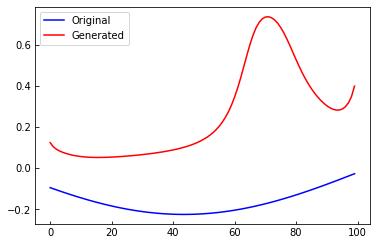

In [30]:
# plots a random example of the origina and predicted spectra

rand = np.random.randint(0, 512)
plt.plot(spectras[rand, :, 0].cpu(), 'b', label='Original')
plt.plot(decoded_[rand].squeeze(), 'r', label='Generated')
plt.legend()

* Reconstruction is slightly better but just more overfit

In [31]:
# builds the spectra from the parameters

(nala_spectra, _) = constructor.compute(_nala_params)

# generated the encoded representation and decoded spectra

(nala_encoded_, nala_decoded_) = transform_nn(nala_spectra, encoder,
        decoder)

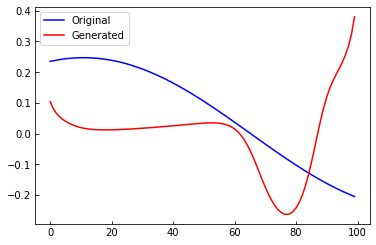

In [32]:
# plots a random example of the origina and predicted spectra

rand = np.random.randint(0, nala_spectra.shape[0])
plt.plot(nala_spectra[rand, :, 0].cpu(), 'b', label='Original')
plt.plot(nala_decoded_[rand].squeeze(), 'r', label='Generated')
plt.legend()


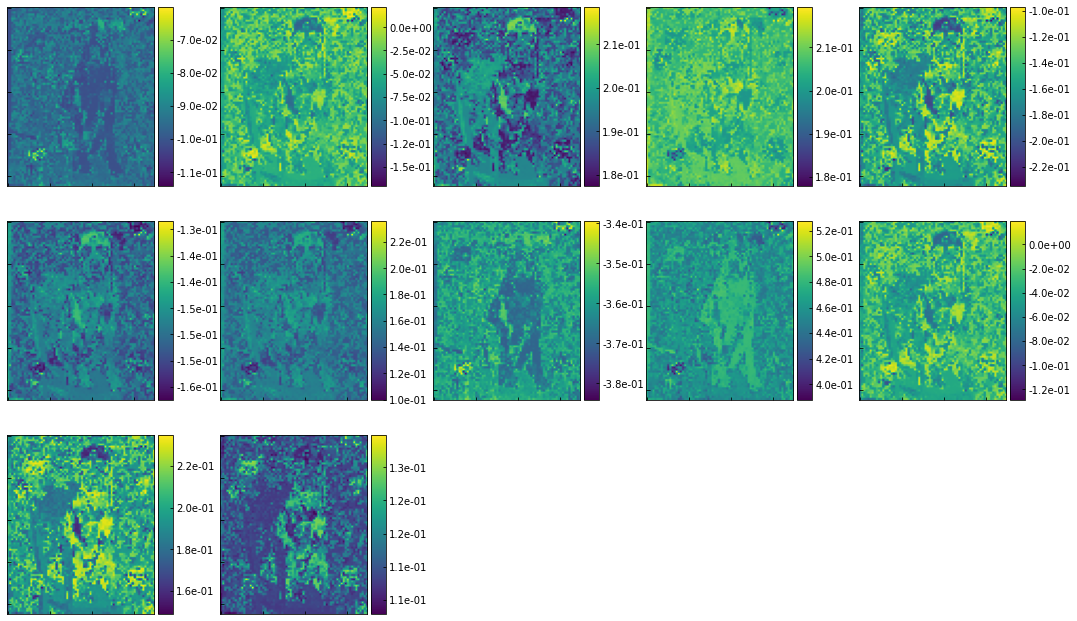

In [33]:
# Visualize the learned embeddings

viz.embedding_maps(nala_encoded_, image)

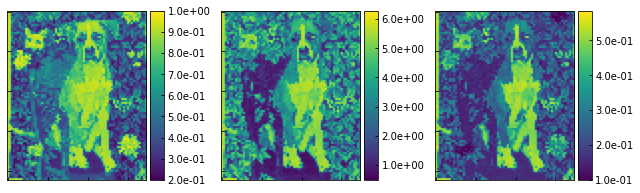

In [34]:
# visualize the actual RGB channels.

viz.embedding_maps(_nala_params.reshape(-1,3), image)

## Now there are just more features but still no resemblance between the parameters.

# Physics constrained neural network

In [66]:
import torch.nn as nn
import torch


class DensePhysLarger(nn.Module):

    def __init__(
        self,
        x_vector,
        model,
        dense_params=3,
        verbose=False,
        device='cuda',
        num_channels=1,
        **kwargs
        ):
        """

        Args:
            x_vector: The vector of values for x
            model: the empirical function to fit
            dense_params: number of output parameters to the model
            verbose: sets if the model is verbose
            device: device where the model will run
            num_channels: number of channels in the input
        """

        super().__init__()
        self.dense_params = dense_params
        self.x_vector = x_vector
        self.verbose = verbose
        self.num_channels = num_channels
        self.device = device
        self.model_params = kwargs.get('model_params')
        self.model = model  # (self.x_vector, size=(num_channels, dense_params // self.model_params))
        self.sigmoid = nn.Sigmoid()
        n = 4

        if torch.cuda.is_available():
            self.cuda()

        # Input block of 1d convolution

        self.hidden_x1 = nn.Sequential(
            nn.Conv1d(in_channels=self.num_channels, out_channels=8
                      * n, kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=8 * n, out_channels=6 * n,
                      kernel_size=7),
            nn.SELU(),
            nn.Conv1d(in_channels=6 * n, out_channels=4,
                      kernel_size=5),
            nn.SELU(),
            )

        self.hidden_x1_shape = self.hidden_x1(torch.zeros(1,
                self.num_channels, self.x_vector.shape[0])).shape

        # fully connected block

        self.hidden_xfc = \
            nn.Sequential(nn.Linear(self.hidden_x1_shape[1]
                          * self.hidden_x1_shape[2], 20), nn.SELU(),
                          nn.Linear(20, 20), nn.SELU())

           # out of size 20

        self.hidden_xfc_shape = self.hidden_xfc(torch.zeros(1,
                self.hidden_x1_shape[1]
                * self.hidden_x1_shape[2])).shape

        # 2nd block of 1d-conv layers

        self.hidden_x2 = nn.Sequential(
            nn.MaxPool1d(kernel_size=2),
            nn.Conv1d(in_channels=1, out_channels=4 * n,
                      kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n,
                      kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n,
                      kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n,
                      kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n,
                      kernel_size=5),
            nn.SELU(),
            nn.Conv1d(in_channels=4 * n, out_channels=4 * n,
                      kernel_size=5),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=4 * n, out_channels=2 * n,
                      kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            nn.Conv1d(in_channels=2 * n, out_channels=2,
                      kernel_size=3),
            nn.SELU(),
            nn.AvgPool1d(kernel_size=2),
            )

        self.hidden_x2_shape = \
            self.hidden_x2(torch.zeros((self.hidden_xfc_shape[0], 1,
                           self.hidden_x1_shape[1]
                           * self.hidden_x1_shape[2]))).shape

        # Flatten layer

        self.flatten_layer = nn.Flatten()

        # Final embedding block - Output 4 values - linear

        self.hidden_embedding = \
            nn.Sequential(nn.Linear(self.hidden_x2_shape[1]
                          * self.hidden_x2_shape[2]
                          + self.hidden_xfc_shape[1], 16), nn.SELU(),
                          nn.Linear(16, 8), nn.SELU(), nn.Linear(8,
                          self.dense_params))

    def forward(self, x, n=-1):

        x = self.hidden_x1(x)
        xfc = torch.reshape(x, (x.shape[0], -1))  # batch size, features
        xfc = self.hidden_xfc(xfc)
        x = torch.reshape(x, (x.shape[0], 1, self.hidden_x1_shape[1]
                          * self.hidden_x1_shape[2]))
        x = self.hidden_x2(x)
        cnn_flat = self.flatten_layer(x)
        encoded = torch.cat((cnn_flat, xfc), 1)  # merge dense and 1d conv.

        embedding = self.hidden_embedding(encoded)  # output is 3 parameters

        embedding = torch.reshape(embedding, (embedding.shape[0], 3,
                                  -1))

        embedding[:, 0, :] = embedding[:, 0, :] * self.model.amp_sd \
            + self.model.amp_mean
        embedding[:, 1, :] = embedding[:, 1, :] * self.model.phase_sd \
            + self.model.phase_mean
        embedding[:, 2, :] = embedding[:, 2, :] \
            * self.model.frequency_sd + self.model.frequency_mean

        embedding = torch.reshape(embedding, (embedding.shape[0], -1))

        embedding = torch.abs(embedding)
        self.embed = embedding

        (out, _) = self.model.compute(embedding, device=self.device)

        out = torch.transpose(out, 1, 2)
        out = torch.atleast_3d(out)

        return (out.to(self.device), embedding.to(self.device))


In [67]:
x_vector = torch.linspace(0, 10, 100)

model = DensePhysLarger(x_vector, constructor, dense_params=3,
                        model_params=3, verbose=False)

if torch.cuda.is_available():
    model.cuda()


In [68]:
# builds the dataloader

dataloader = DataLoader(torch.transpose(spectra_full,1,2), batch_size=512,
                         shuffle=True, num_workers=0)

In [69]:
torch.manual_seed(0)

loss_func = torch.nn.MSELoss()

optimizer = torch.optim.Adam(model.parameters(), lr=3e-5)


epochs = 25
    
for epoch in range(epochs):
  start_time = time.time()

  train_loss = 0.
  total_num = 0

  model.train()
    
  for train_batch in dataloader:
    pred, _ = model(train_batch.cuda())

    optimizer.zero_grad()
    
    loss = loss_func(train_batch.cuda(), pred)
    loss.backward(create_graph=True)
    train_loss += loss.item() * pred.shape[0]
    total_num += pred.shape[0]

    optimizer.step()

  train_loss /= total_num

  print("epoch : {}/{}, recon loss = {:.8f}".format(epoch, epochs, train_loss))
  print("--- %s seconds ---" % (time.time() - start_time))

epoch : 0/25, recon loss = 0.33886067
--- 2.9767589569091797 seconds ---
epoch : 1/25, recon loss = 0.31859685
--- 2.955799102783203 seconds ---
epoch : 2/25, recon loss = 0.29782668
--- 2.953491449356079 seconds ---
epoch : 3/25, recon loss = 0.27729173
--- 2.960805654525757 seconds ---
epoch : 4/25, recon loss = 0.25875369
--- 2.969945192337036 seconds ---
epoch : 5/25, recon loss = 0.24088302
--- 2.9680447578430176 seconds ---
epoch : 6/25, recon loss = 0.22407392
--- 2.9741475582122803 seconds ---
epoch : 7/25, recon loss = 0.20872623
--- 2.9682366847991943 seconds ---
epoch : 8/25, recon loss = 0.19564475
--- 2.98069429397583 seconds ---
epoch : 9/25, recon loss = 0.18506433
--- 2.9760963916778564 seconds ---
epoch : 10/25, recon loss = 0.17680810
--- 2.9762659072875977 seconds ---
epoch : 11/25, recon loss = 0.17026110
--- 2.967031240463257 seconds ---
epoch : 12/25, recon loss = 0.16474528
--- 2.9653239250183105 seconds ---
epoch : 13/25, recon loss = 0.15978518
--- 2.9610035419

tensor([0.3562, 3.7256, 0.3491], device='cuda:0', grad_fn=<SelectBackward>)


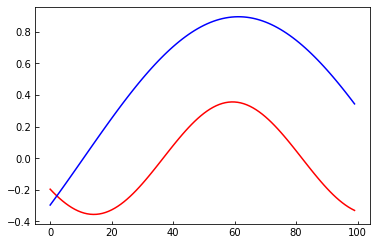

In [71]:
spectra_generated, params = model(train_batch.cuda())
rand = np.random.randint(0,272)
plt.plot(spectra_generated[rand,0,:].detach().cpu().numpy(),'r')
plt.plot(train_batch[rand,0,:],'b')
print(params[rand])

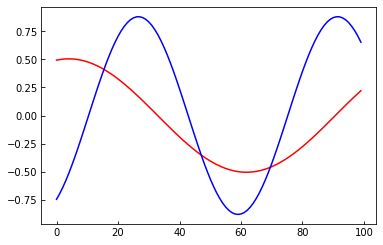

In [72]:
nala_spectra_generated, nala_params = model(nala_spectra.transpose(2,1).cuda())
rand = np.random.randint(0,nala_spectra_generated.shape[0])
plt.plot(nala_spectra_generated[rand,0,:].detach().cpu().numpy(),'r')
plt.plot(nala_spectra[rand,:,0],'b')

In [73]:
nala_params[:,1] = nala_params[:,1] % 2*np.pi

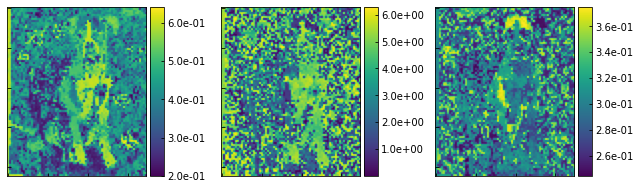

In [74]:
# Visualize the learned embeddings

viz.embedding_maps(nala_params.detach().cpu().numpy(), image)

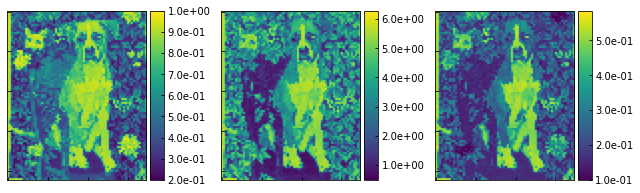

In [75]:
# visualize the actual RGB channels.

viz.embedding_maps(_nala_params.reshape(-1,3), image)

# Try with a better optimizer AdaHessian

In [44]:
"""
Created on Sun Feb 26 16:34:00 2021
@author: Amir Gholami
@coauthor: David Samuel
"""

import numpy as np
import torch

class AdaHessian(torch.optim.Optimizer):
    """
    Implements the AdaHessian algorithm from "ADAHESSIAN: An Adaptive Second OrderOptimizer for Machine Learning"
    Arguments:
        params (iterable) -- iterable of parameters to optimize or dicts defining parameter groups
        lr (float, optional) -- learning rate (default: 0.1)
        betas ((float, float), optional) -- coefficients used for computing running averages of gradient and the squared hessian trace (default: (0.9, 0.999))
        eps (float, optional) -- term added to the denominator to improve numerical stability (default: 1e-8)
        weight_decay (float, optional) -- weight decay (L2 penalty) (default: 0.0)
        hessian_power (float, optional) -- exponent of the hessian trace (default: 1.0)
        update_each (int, optional) -- compute the hessian trace approximation only after *this* number of steps (to save time) (default: 1)
        n_samples (int, optional) -- how many times to sample `z` for the approximation of the hessian trace (default: 1)
    """

    def __init__(self, params, lr=0.1, betas=(0.9, 0.999), eps=1e-8, weight_decay=0.0, 
                 hessian_power=1.0, update_each=1, n_samples=1, average_conv_kernel=False):
        if not 0.0 <= lr:
            raise ValueError(f"Invalid learning rate: {lr}")
        if not 0.0 <= eps:
            raise ValueError(f"Invalid epsilon value: {eps}")
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 0: {betas[0]}")
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError(f"Invalid beta parameter at index 1: {betas[1]}")
        if not 0.0 <= hessian_power <= 1.0:
            raise ValueError(f"Invalid Hessian power value: {hessian_power}")

        self.n_samples = n_samples
        self.update_each = update_each
        self.average_conv_kernel = average_conv_kernel

        # use a separate generator that deterministically generates the same `z`s across all GPUs in case of distributed training
        self.generator = torch.Generator().manual_seed(2147483647)

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, hessian_power=hessian_power)
        super(AdaHessian, self).__init__(params, defaults)

        for p in self.get_params():
            p.hess = 0.0
            self.state[p]["hessian step"] = 0

    def get_params(self):
        """
        Gets all parameters in all param_groups with gradients
        """

        return (p for group in self.param_groups for p in group['params'] if p.requires_grad)

    def zero_hessian(self):
        """
        Zeros out the accumalated hessian traces.
        """

        for p in self.get_params():
            if not isinstance(p.hess, float) and self.state[p]["hessian step"] % self.update_each == 0:
                p.hess.zero_()

    @torch.no_grad()
    def set_hessian(self):
        """
        Computes the Hutchinson approximation of the hessian trace and accumulates it for each trainable parameter.
        """

        params = []
        for p in filter(lambda p: p.grad is not None, self.get_params()):
            if self.state[p]["hessian step"] % self.update_each == 0:  # compute the trace only each `update_each` step
                params.append(p)
            self.state[p]["hessian step"] += 1

        if len(params) == 0:
            return

        if self.generator.device != params[0].device:  # hackish way of casting the generator to the right device
            self.generator = torch.Generator(params[0].device).manual_seed(2147483647)

        grads = [p.grad for p in params]

        for i in range(self.n_samples):
            zs = [torch.randint(0, 2, p.size(), generator=self.generator, device=p.device) * 2.0 - 1.0 for p in params]  # Rademacher distribution {-1.0, 1.0}
            h_zs = torch.autograd.grad(grads, params, grad_outputs=zs, only_inputs=True, retain_graph=i < self.n_samples - 1)
            for h_z, z, p in zip(h_zs, zs, params):
                p.hess += h_z * z / self.n_samples  # approximate the expected values of z*(H@z)

    @torch.no_grad()
    def step(self, closure=None):
        """
        Performs a single optimization step.
        Arguments:
            closure (callable, optional) -- a closure that reevaluates the model and returns the loss (default: None)
        """

        loss = None
        if closure is not None:
            loss = closure()

        self.zero_hessian()
        self.set_hessian()

        for group in self.param_groups:
            for p in group['params']:
                if p.grad is None or p.hess is None:
                    continue

                if self.average_conv_kernel and p.dim() == 4:
                    p.hess = torch.abs(p.hess).mean(dim=[2, 3], keepdim=True).expand_as(p.hess).clone()

                # Perform correct stepweight decay as in AdamW
                p.mul_(1 - group['lr'] * group['weight_decay'])

                state = self.state[p]

                # State initialization
                if len(state) == 1:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p.data)  # Exponential moving average of gradient values
                    state['exp_hessian_diag_sq'] = torch.zeros_like(p.data)  # Exponential moving average of Hessian diagonal square values

                exp_avg, exp_hessian_diag_sq = state['exp_avg'], state['exp_hessian_diag_sq']
                beta1, beta2 = group['betas']
                state['step'] += 1

                # Decay the first and second moment running average coefficient
                exp_avg.mul_(beta1).add_(p.grad, alpha=1 - beta1)
                exp_hessian_diag_sq.mul_(beta2).addcmul_(p.hess, p.hess, value=1 - beta2)

                bias_correction1 = 1 - beta1 ** state['step']
                bias_correction2 = 1 - beta2 ** state['step']

                k = group['hessian_power']
                denom = (exp_hessian_diag_sq / bias_correction2).pow_(k / 2).add_(group['eps'])

                # make update
                step_size = group['lr'] / bias_correction1
                p.addcdiv_(exp_avg, denom, value=-step_size)

        return loss

In [76]:
x_vector = torch.linspace(0, 10, 100)

model = DensePhysLarger(x_vector, constructor, dense_params=3,
                        model_params=3, verbose=False)

if torch.cuda.is_available():
    model.cuda()


In [77]:
# builds the dataloader

dataloader = DataLoader(torch.transpose(spectra_full,1,2), batch_size=512,
                         shuffle=True, num_workers=0)

In [87]:
torch.manual_seed(0)

loss_func = torch.nn.MSELoss()

# Use AdaHessian

optimizer = AdaHessian(model.parameters(), lr=0.1)

epochs = 600
    
for epoch in range(epochs):
  start_time = time.time()

  train_loss = 0.
  total_num = 0

  model.train()
    
  for train_batch in dataloader:
    pred, _ = model(train_batch.cuda())

    optimizer.zero_grad()
    
    loss = loss_func(train_batch.cuda(), pred)
    loss.backward(create_graph=True)
    train_loss += loss.item() * pred.shape[0]
    total_num += pred.shape[0]

    optimizer.step()

  train_loss /= total_num

  print("epoch : {}/{}, recon loss = {:.8f}".format(epoch, epochs, train_loss))
  print("--- %s seconds ---" % (time.time() - start_time))

epoch : 0/600, recon loss = 0.02921981
--- 6.691569089889526 seconds ---
epoch : 1/600, recon loss = 0.01790533
--- 6.717973709106445 seconds ---
epoch : 2/600, recon loss = 0.01576213
--- 6.711328983306885 seconds ---
epoch : 3/600, recon loss = 0.01532522
--- 6.717994928359985 seconds ---
epoch : 4/600, recon loss = 0.01473082
--- 6.712644815444946 seconds ---
epoch : 5/600, recon loss = 0.01416881
--- 6.7311482429504395 seconds ---
epoch : 6/600, recon loss = 0.01381171
--- 6.730431079864502 seconds ---
epoch : 7/600, recon loss = 0.01375032
--- 6.737527370452881 seconds ---
epoch : 8/600, recon loss = 0.01388209
--- 6.734651327133179 seconds ---
epoch : 9/600, recon loss = 0.01377409
--- 6.735780239105225 seconds ---
epoch : 10/600, recon loss = 0.01317185
--- 6.7276291847229 seconds ---
epoch : 11/600, recon loss = 0.01293439
--- 6.734343528747559 seconds ---
epoch : 12/600, recon loss = 0.01324568
--- 6.723811626434326 seconds ---
epoch : 13/600, recon loss = 0.01229717
--- 6.744

tensor([0.2405, 5.5421, 0.1550], device='cuda:0', grad_fn=<SelectBackward>)


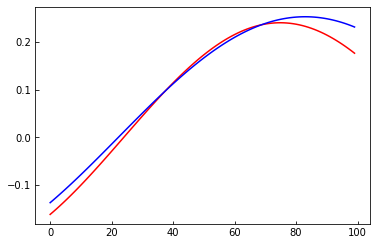

In [95]:
spectra_generated, params = model(train_batch.cuda())
rand = np.random.randint(0,272)
plt.plot(spectra_generated[rand,0,:].detach().cpu().numpy(),'r')
plt.plot(train_batch[rand,0,:],'b')
print(params[rand])

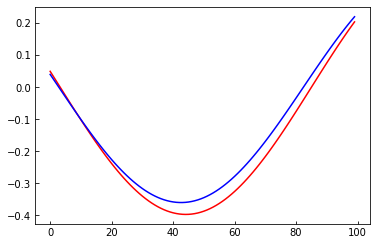

In [97]:
nala_spectra_generated, nala_params = model(nala_spectra.transpose(2,1).cuda())
rand = np.random.randint(0,nala_spectra_generated.shape[0])
plt.plot(nala_spectra_generated[rand,0,:].detach().cpu().numpy(),'r')
plt.plot(nala_spectra[rand,:,0],'b')

In [98]:
nala_params[:,1] = nala_params[:,1] % 2*np.pi

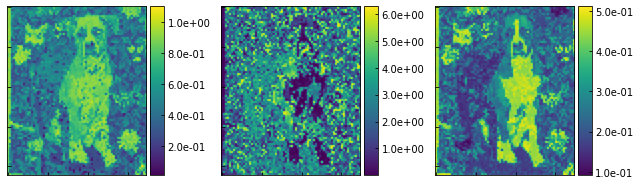

In [99]:
# Visualize the learned embeddings

viz.embedding_maps(nala_params.detach().cpu().numpy(), image)

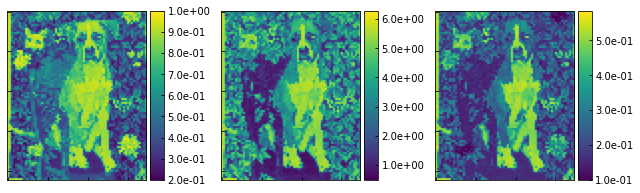

In [86]:
# visualize the actual RGB channels.

viz.embedding_maps(_nala_params.reshape(-1,3), image)

In [100]:
trained_model = torch.load('/content/AI_For_Atoms_Autoencoder_Tutorial/adahessian 600 epoch')

tensor([0.4409, 3.8105, 0.3701], device='cuda:0', grad_fn=<SelectBackward>)


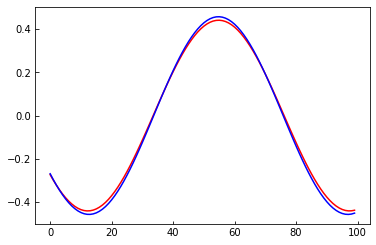

In [102]:
spectra_generated, params = trained_model(train_batch.cuda())
rand = np.random.randint(0,272)
plt.plot(spectra_generated[rand,0,:].detach().cpu().numpy(),'r')
plt.plot(train_batch[rand,0,:],'b')
print(params[rand])

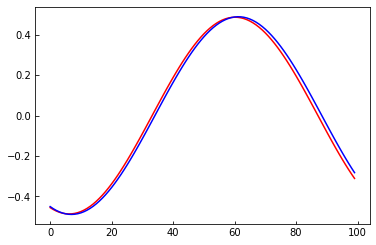

In [103]:
nala_spectra_generated, nala_params = trained_model(nala_spectra.transpose(2,1).cuda())
rand = np.random.randint(0,nala_spectra_generated.shape[0])
plt.plot(nala_spectra_generated[rand,0,:].detach().cpu().numpy(),'r')
plt.plot(nala_spectra[rand,:,0],'b')

In [104]:
nala_params[:,1] = nala_params[:,1] % 2*np.pi

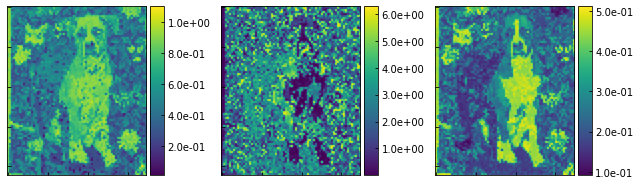

In [105]:
# Visualize the learned embeddings

viz.embedding_maps(nala_params.detach().cpu().numpy(), image)

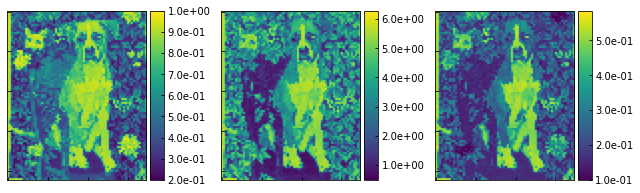

In [ ]:
# visualize the actual RGB channels.

viz.embedding_maps(_nala_params.reshape(-1,3), image)